# 0.0. IMPORTS

In [2]:
import pandas            as pd
import numpy             as np
import matplotlib.pyplot as plt
import seaborn           as sns
import inflection
import math
import datetime
import xgboost           as xgb
import random
import warnings


from matplotlib            import pyplot   as plt
from matplotlib            import gridspec as gdc
from scipy                 import stats    as ss
from IPython.core.display  import HTML
from IPython.display       import Image
from tabulate              import tabulate
from sklearn.preprocessing import RobustScaler, MinMaxScaler, LabelEncoder
from boruta                import BorutaPy
from sklearn.ensemble      import RandomForestRegressor
from sklearn.metrics       import mean_absolute_error, mean_squared_error
from sklearn.linear_model  import LinearRegression, Lasso

warnings.filterwarnings( 'ignore' )

### requeriments by Norton
Flask==1.1.2
inflection==0.5.1
pandas==1.3.5
scikit-learn==0.24.1
scipy==1.7.3
sklearn==0.0
xgboost==0.90

## 0.2. Helper Funcions

In [3]:
def cross_validation( x_training, kfold, model_name, model, verbose=False):
    mae_list = []
    mape_list = []
    rmse_list =[]
    for k in reversed( range( 1, kfold+1 ) ):
        if verbose:
            print('\nKfold Number: {}'.format( k ) )
        # start and end date for validation 
        validation_start_date = x_training['date'].max() - datetime.timedelta( days = k*6*7 )
        validation_end_date = x_training['date'].max() - datetime.timedelta( days = (k-1)*6*7 )

        #filtering dataset
        training = x_training[x_training['date'] < validation_start_date]
        validation = x_training[(x_training['date'] >= validation_start_date) & 
                            (x_training['date'] <= validation_end_date)]

        # Training and validation dataset
        #training
        xtraining = training.drop(['date', 'sales'], axis = 1)
        ytraining = training['sales']

        # validation
        xvalidation = validation.drop(['date', 'sales'], axis = 1)
        yvalidation = validation['sales']

        # model
        m = model.fit( xtraining, ytraining )

        #prediction
        yhat = m.predict( xvalidation )

        #performance
        m_result = ml_error( model_name, np.expm1( yvalidation ), np.expm1( yhat ))

        # store performance of each kfold iteration
        mae_list.append ( m_result['MAE']  )
        mape_list.append( m_result['MAPE'] )
        rmse_list.append( m_result['RMSE'] )

        
    return pd.DataFrame({'Model Name' : model_name,
                         'MAE CV'     : np.round( np.mean ( mae_list ), 2).astype( str ) + '+/-' + np.round( np.std( mae_list), 2).astype( str ),
                         'MAP CV'     : np.round( np.mean ( mape_list ), 2).astype( str ) + '+/-' + np.round( np.std( mape_list), 2).astype( str ),
                         'RSE CV'     : np.round( np.mean ( rmse_list ), 2).astype( str ) + '+/-' + np.round( np.std( rmse_list), 2).astype( str )}, index=[0])

def cramer_v( x, y ):
    cm = pd.crosstab( x, y ).values
    n= cm.sum()
    r, k = cm.shape
    
    chi2 = ss.chi2_contingency( cm )[0]
    chi2corr = max( 0 , chi2 - ( k-1 ) * ( r - 1 )/( n - 1) )
    
    kcorr = k - ( k-1 )**2/( n - 1 )
    rcorr = r - ( k-1 )**2/( n - 1 )
    
    return np.sqrt( (chi2corr/n) / (min( kcorr-1, rcorr-1 ) ) )

def mean_percentage_error( y, yhat ):
    return np.mean( ( y - yhat ) / y )

def mean_absolute_percentage_error( y, yhat ):
    return np.mean( np.abs( ( y - yhat ) / y ) )
    
def ml_error( model_name, y, yhat ):
    mae = mean_absolute_error( y, yhat )
    mape = mean_absolute_percentage_error( y, yhat )
    rmse = np.sqrt( mean_squared_error( y, yhat ) )
    
    return pd.DataFrame( { 'Model Name': model_name, 
                           'MAE': mae, 
                           'MAPE': mape,
                           'RMSE': rmse }, index=[0] )


        



## 0.3. Loading data

In [4]:
df_sales_raw = pd.read_csv( 'data/train.csv', low_memory=False )
df_store_raw = pd.read_csv( 'data/store.csv', low_memory=False )

# merge
df_raw = pd.merge( df_sales_raw, df_store_raw, how= 'left',on = 'Store' )

# 1.0. DESCRIÇÃO DOS DADOS

## 1.1.  Rename Columns


In [4]:
df1 = df_raw.copy()

In [5]:
cols_old = ['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo','StateHoliday',                           'SchoolHoliday', 'StoreType', 'Assortment', 'CompetitionDistance', 'CompetitionOpenSinceMonth',
            'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek', 'Promo2SinceYear', 'PromoInterval']

#put snakecase
snakecase = lambda x: inflection.underscore( x )

cols_new = list( map( snakecase, cols_old ) )

#rename columns
df1.columns = cols_new

In [6]:
df1.columns

Index(['store', 'day_of_week', 'date', 'sales', 'customers', 'open', 'promo',
       'state_holiday', 'school_holiday', 'store_type', 'assortment',
       'competition_distance', 'competition_open_since_month',
       'competition_open_since_year', 'promo2', 'promo2_since_week',
       'promo2_since_year', 'promo_interval'],
      dtype='object')

## 1.2. Data Dimensions

In [7]:
print( 'Number of Rows: {}'.format( df1.shape[0] ) )
print( 'Number of cols: {}'.format( df1.shape[1] ) )

Number of Rows: 1017209
Number of cols: 18


## 1.3.  Data Types

In [8]:
df1['date'] = pd.to_datetime( df1['date'])
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
dtype: object

## 1.4.  Check NA

In [9]:
df1.isna().sum()

store                                0
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
store_type                           0
assortment                           0
competition_distance              2642
competition_open_since_month    323348
competition_open_since_year     323348
promo2                               0
promo2_since_week               508031
promo2_since_year               508031
promo_interval                  508031
dtype: int64

## 1.5.  Fillout NA

In [10]:
df1['competition_distance'].max()

75860.0

In [11]:
#competition_distance(distância de uma loja concorrente) 
#Assumiremos que quando tem um NA não existe competidor ou esta muito distante.
#Assim substiruiremos por um valor muito maior que o encontrado no dataset(75860m)
df1['competition_distance'] = df1['competition_distance'].apply( lambda x: 
                                                                200000.0 if math.isnan( x ) else x)

#competition_open_since_month    
df1['competition_open_since_month'] = df1.apply( lambda x: 
                                                x['date'].month if 
                                                math.isnan( x['competition_open_since_month']) else x['competition_open_since_month'], axis = 1 )       
                                                                                    

#competition_open_since_year   
df1['competition_open_since_year'] = df1.apply( lambda x: 
                                                x['date'].year if 
                                                math.isnan( x['competition_open_since_year']) else x['competition_open_since_year'], axis = 1 )                                                                                     
#promo2_since_week  
df1[ 'promo2_since_week' ] = df1.apply( lambda x: 
                                                x['date'].week if 
                                                math.isnan( x['promo2_since_week']) else x['promo2_since_week'], axis = 1) 

#promo2_since_year  
df1['promo2_since_year'] = df1.apply( lambda x: x['date'].year if math.isnan( x['promo2_since_year'] ) else x['promo2_since_year'], axis=1 ) 

#promo_interval         
month_map = {1:  'Jan', 2:  'Fev', 3:  'Mar', 4:  'Apr', 5:  'May', 6:  'Jun', 7:  'Jul', 8:  'Aug', 9:  'Sep', 10: 'Oct', 11: 'Nov', 12: 'Dec', }

df1['promo_interval'].fillna(0, inplace = True )

df1['month_map'] = df1['date'].dt.month.map( month_map )

df1['is_promo'] = df1[['promo_interval', 'month_map']].apply( lambda x: 0 if x['promo_interval'] == 0 else 1 if x['month_map'] in x['promo_interval'].split( ',' ) else 0, axis=1 )


In [12]:
df1.sample(5).T

,194848,100404,936971,232424,36632
store,839,55,42,505,953
day_of_week,6,6,3,7,1
date,2015-02-07 00:00:00,2015-05-02 00:00:00,2013-03-13 00:00:00,2015-01-04 00:00:00,2015-06-29 00:00:00
sales,2191,4243,8871,0,7859
customers,285,511,1070,0,613
open,1,1,1,0,1
promo,0,0,0,0,1
state_holiday,0,0,0,0,0
school_holiday,0,0,0,0,0
store_type,c,a,a,a,a


## 1.6. Change Types

In [13]:
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
month_map                               object
is_promo                                 int64
dtype: object

In [14]:
df1['competition_open_since_month'] = df1['competition_open_since_month'].astype( int )             
df1['competition_open_since_year'] =  df1['competition_open_since_year'].astype( int )  
df1['promo2_since_week'] = df1['promo2_since_week'].astype( int )                    
df1['promo2_since_year'] =  df1['promo2_since_year'].astype( int )                     

## 1.7. Descriptive Statistical

In [15]:
num_attributes = df1.select_dtypes( include=['int64', 'float64'] )
cat_attributes = df1.select_dtypes( exclude = ['int64', 'float64', 'datetime64[ns]'])


### 1.7.1 Numerical Atributes

In [16]:
#Central tendency - mean, median
ct1 = pd.DataFrame( num_attributes.apply( np.mean ) ).T
ct2 = pd.DataFrame( num_attributes.apply( np.median ) ).T

#Dispersion - std, min, max, range, skew, kurtosis 
d1 = pd.DataFrame( num_attributes.apply( np.std) ).T
d2 = pd.DataFrame( num_attributes.apply( min ) ).T
d3 = pd.DataFrame( num_attributes.apply( max ) ).T
d4 = pd.DataFrame( num_attributes.apply( lambda x: x.max() - x.min() ) ).T
d5 = pd.DataFrame( num_attributes.apply( lambda x: x.skew() ) ).T
d6 = pd.DataFrame( num_attributes.apply( lambda x: x.kurtosis() ) ).T



In [17]:
# concatenate
m = pd.concat( [d2, d3, d4, ct1, ct2, d1, d5, d6]).T.reset_index()
m.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']
m

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,store,1.0,1115.0,1114.0,558.429727,558.0,321.908493,-0.000955,-1.200524
1,day_of_week,1.0,7.0,6.0,3.998341,4.0,1.997390,0.001593,-1.246873
2,sales,0.0,41551.0,41551.0,5773.818972,5744.0,3849.924283,0.641460,1.778375
3,customers,0.0,7388.0,7388.0,633.145946,609.0,464.411506,1.598650,7.091773
4,open,0.0,1.0,1.0,0.830107,1.0,0.375539,-1.758045,1.090723
5,promo,0.0,1.0,1.0,0.381515,0.0,0.485758,0.487838,-1.762018
6,school_holiday,0.0,1.0,1.0,0.178647,0.0,0.383056,1.677842,0.815154
7,competition_distance,20.0,200000.0,199980.0,5935.442677,2330.0,12547.646829,10.242344,147.789712
8,competition_open_since_month,1.0,12.0,11.0,6.786849,7.0,3.311085,-0.042076,-1.232607
9,competition_open_since_year,1900.0,2015.0,115.0,2010.324840,2012.0,5.515591,-7.235657,124.071304


### 1.7.2 Categorical Atributes

In [18]:
cat_attributes.apply( lambda x: x.unique().shape[0] )

state_holiday      4
store_type         4
assortment         3
promo_interval     4
month_map         12
dtype: int64

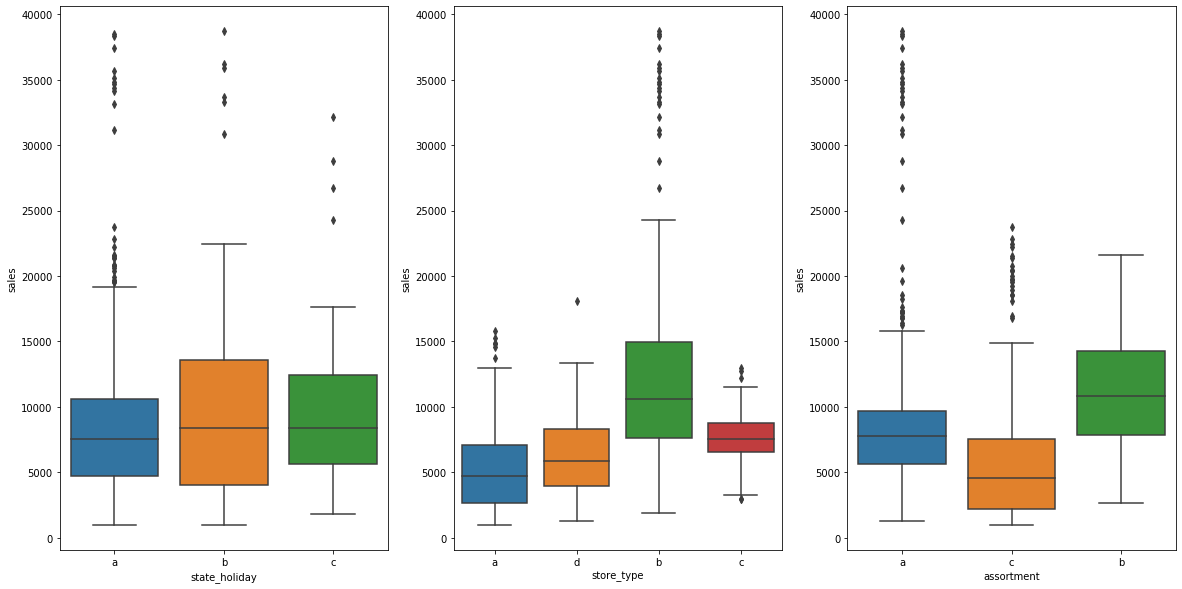

In [19]:
aux = df1[(df1['state_holiday'] != '0') & (df1['sales'] > 0)]

plt.subplot( 1, 3, 1 )
sns.boxplot( x='state_holiday', y='sales', data=aux, width = 0.8 ).figure.set_size_inches(20,10)

plt.subplot( 1, 3, 2 )
sns.boxplot( x='store_type', y='sales', data=aux, width = 0.8 )

plt.subplot( 1, 3, 3 )
sns.boxplot( x='assortment', y='sales', data=aux, width = 0.8 )







# 2.0. FEATURE ENGINEERING

In [20]:
df2 = df1.copy()

## 2.1. Mapa Mental de Hipoteses

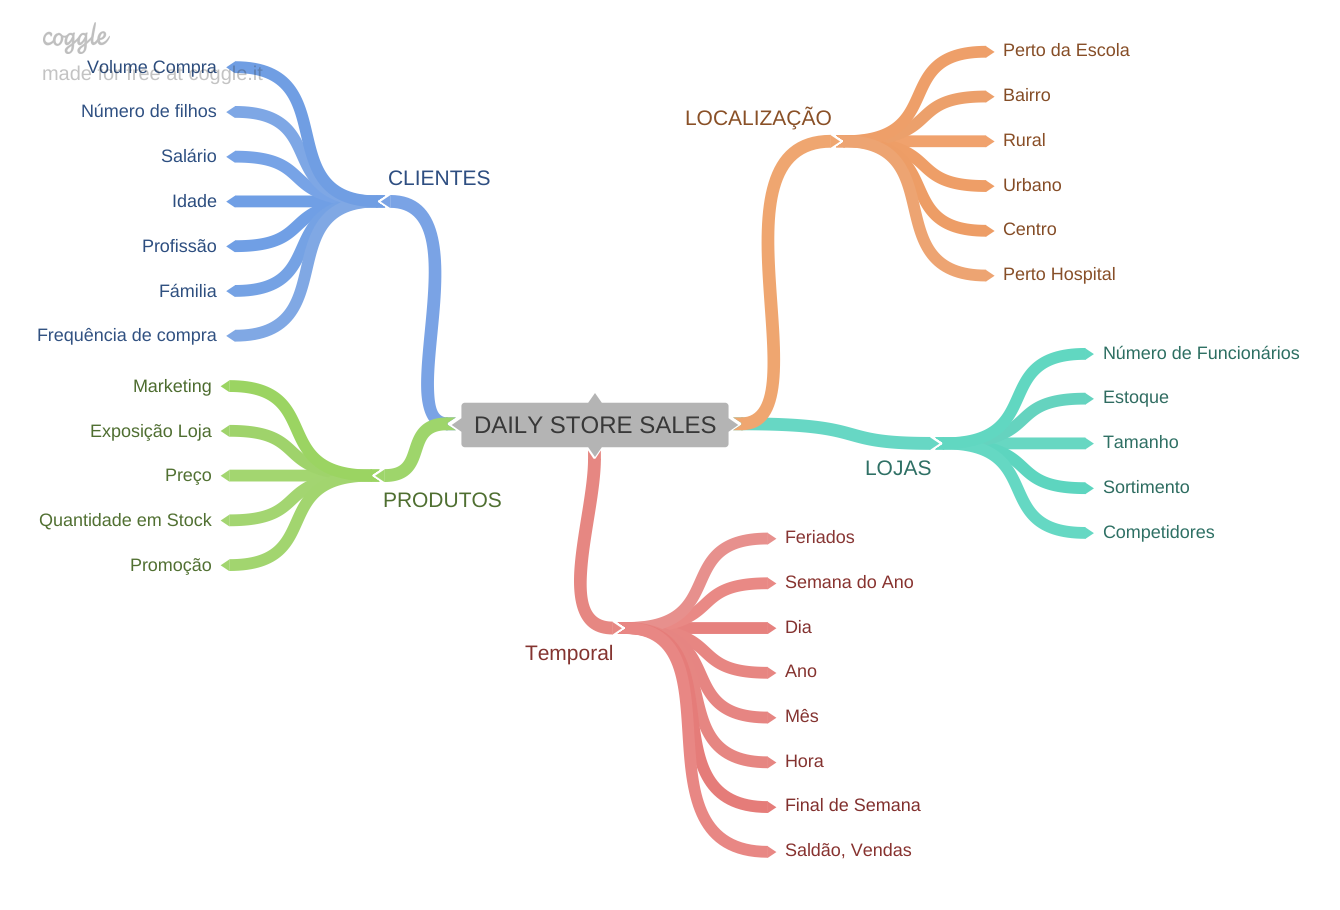

In [21]:
Image( 'img/mindmaphypothesis.png' )

## 2.2.  Criação das Hipóteses

### 2.2.1. Hipoteses Loja

**1.** Lojas com número maior de funcionários deveriam vender mais.

**2.** Lojas com maior capacidade de estoque deveriam vender mais.

**3.** Lojas com maior porte deveriam vender mais.

**4.** Lojas com maior sortimentos deveriam vender mais.

**5.** Lojas com competidores mais próximos deveriam vender menos.

**6.** Lojas com competidores à mais tempo deveriam vendem mais.



### 2.2.2. Hipoteses Produto

**1.** Lojas que investem mais em Marketing devriam vender mais

**2.** Lojas maior exposição do produto deveriam vender mais. 

**3.** Lojas com podutos com preço menor deveriam vender mais.

**4.** Lojas promoções mais agressivas(descontos maiores), deveriam vender mais

**5.** Lojas com promoção ativas por mais tempo deveriam vender mais. 

**6.** Lojas com mais dias de promoção deveriam vender mais. 

**7.** Lojas com mais promoção consecutivas deveriam vender mais. 



### 2.2.1. Hipoteses Tempo

**1.** Lojas abertas durante o feriado de Natal deveriam vender mais.

**2.** Lojas deveriam vender mais ao longo dos anos.

**3.** Lojas deveriam vender mais no segundo semestre do ano.

**4.** Lojas deveriam vender mais depois do dia 10 de cada mês.

**5.** Lojas deveriam vender menos aos finais de semana.

**6.** Lojas deveriam vender menos durante os feriados escolares.


## 2.3.  Criação Final de Hipóteses

**1.** Lojas com maior sortimentos deveriam vender mais.

**2.** Lojas com competidores mais próximos deveriam vender menos.

**3.** Lojas com competidores à mais tempo deveriam vendem mais.

**4.** Lojas com promoção ativas por mais tempo deveriam vender mais. 

**5.** Lojas com mais dias de promoção deveriam vender mais. 

**6.** Lojas com mais promoção consecutivas deveriam vender mais. 

**7.** Lojas abertas durante o feriado de Natal deveriam vender mais.

**8.** Lojas deveriam vender mais ao longo dos anos.

**9.** Lojas deveriam vender mais no segundo semestre do ano.

**10.** Lojas deveriam vender mais depois do dia 10 de cada mês.

**11.** Lojas deveriam vender menos aos finais de semana.

**12.** Lojas deveriam vender menos durante os feriados escolares.



## 2.4.  Feature Engineering

In [22]:
#year
df2['year'] = df2['date'].dt.year

#month
df2['month'] = df2['date'].dt.month

#day
df2['day'] = df2['date'].dt.day

#week of year
df2['week_of_year'] = df2['date'].dt.weekofyear

#year week
df2['year_week'] = df2['date'].dt.strftime( '%Y-%W' )

#competition since
df2['competition_since'] = df2.apply( lambda x: datetime.datetime( year=x['competition_open_since_year'], month=x['competition_open_since_month'],day=1 ), axis=1 )
df2[ 'competition_time_month' ]=(( df2['date'] - df2['competition_since'] )/30 ).apply( lambda x: x.days ).astype( int )

#promo since
df2['promo_since'] = df2[ 'promo2_since_year' ].astype( str ) + '-' + df2['promo2_since_week'].astype( str )

df2['promo_since'] = df2['promo_since'].apply( lambda x : datetime.datetime.strptime( x + '-1', '%Y-%W-%w' ) - datetime.timedelta( days = 7 ) )

df2['promo_time_week'] = ( ( df2['date'] - df2['promo_since'] )/7).apply( lambda x: x.days ).astype( int )

#assortment
#describes: a = basic, b = extra, c = extended

df2['assortment'] = df2['assortment'].apply( lambda x: 'basic' if x == 'a' else 'extra' if x == 'b' else 'extended' )

#state holiday
#a = public holiday, b = Easter holiday, c = Christmas, 0 = None
df2['state_holiday'] = df2['state_holiday'].apply( lambda x: 'public holiday' if x == 'a' else 'Easter holiday' if x == 'b' else 'Christmas' if x == 'c'  else 'regular_day')


In [23]:
df2.head().T

,0,1,2,3,4
store,1,2,3,4,5
day_of_week,5,5,5,5,5
date,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00
sales,5263,6064,8314,13995,4822
customers,555,625,821,1498,559
open,1,1,1,1,1
promo,1,1,1,1,1
state_holiday,regular_day,regular_day,regular_day,regular_day,regular_day
school_holiday,1,1,1,1,1
store_type,c,a,a,c,a


# 3.0. FILTRAGEM DE VARIÁVEIS

In [24]:
df3 = df2.copy()

In [25]:
df3.head()

,store,day_of_week,date,sales,customers,open,promo,state_holiday,school_holiday,store_type,...,is_promo,year,month,day,week_of_year,year_week,competition_since,competition_time_month,promo_since,promo_time_week
0,1,5,2015-07-31,5263,555,1,1,regular_day,1,c,...,0,2015,7,31,31,2015-30,2008-09-01,84,2015-07-27,0
1,2,5,2015-07-31,6064,625,1,1,regular_day,1,a,...,1,2015,7,31,31,2015-30,2007-11-01,94,2010-03-22,279
2,3,5,2015-07-31,8314,821,1,1,regular_day,1,a,...,1,2015,7,31,31,2015-30,2006-12-01,105,2011-03-28,226
3,4,5,2015-07-31,13995,1498,1,1,regular_day,1,c,...,0,2015,7,31,31,2015-30,2009-09-01,71,2015-07-27,0
4,5,5,2015-07-31,4822,559,1,1,regular_day,1,a,...,0,2015,7,31,31,2015-30,2015-04-01,4,2015-07-27,0


## 3.1 Filtragem das Linhas


In [26]:
df3 =df3[( df3['open'] != 0 ) & ( df3['sales'] > 0 )]

## 3.2  Seleção de Colunas

In [27]:
cols_drop = ['customers', 'open', 'promo_interval', 'month_map']
df3 = df3.drop( cols_drop, axis=1 )


In [28]:
df3.head()

,store,day_of_week,date,sales,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,...,is_promo,year,month,day,week_of_year,year_week,competition_since,competition_time_month,promo_since,promo_time_week
0,1,5,2015-07-31,5263,1,regular_day,1,c,basic,1270.0,...,0,2015,7,31,31,2015-30,2008-09-01,84,2015-07-27,0
1,2,5,2015-07-31,6064,1,regular_day,1,a,basic,570.0,...,1,2015,7,31,31,2015-30,2007-11-01,94,2010-03-22,279
2,3,5,2015-07-31,8314,1,regular_day,1,a,basic,14130.0,...,1,2015,7,31,31,2015-30,2006-12-01,105,2011-03-28,226
3,4,5,2015-07-31,13995,1,regular_day,1,c,extended,620.0,...,0,2015,7,31,31,2015-30,2009-09-01,71,2015-07-27,0
4,5,5,2015-07-31,4822,1,regular_day,1,a,basic,29910.0,...,0,2015,7,31,31,2015-30,2015-04-01,4,2015-07-27,0


# 4.0. ANALISE EXPLORATÓRIA DOS DADOS

In [29]:
df4 = df3.copy()

## 4.1 Analise Univariada


Na analise Univariada, fazemos uma analise olhando unicamente para todas as variáveis

### 4.1.1. Response Variable

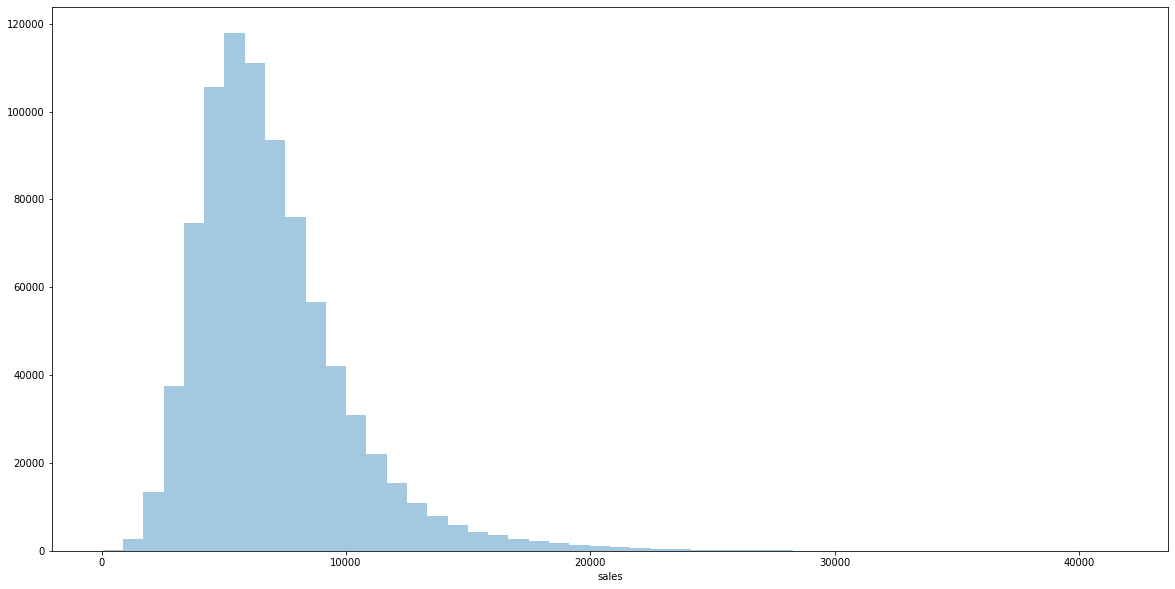

In [30]:
sns.distplot( (df4['sales'] ), kde = False).figure.set_size_inches(20,10)

### 4.1.2 Numerical Variable

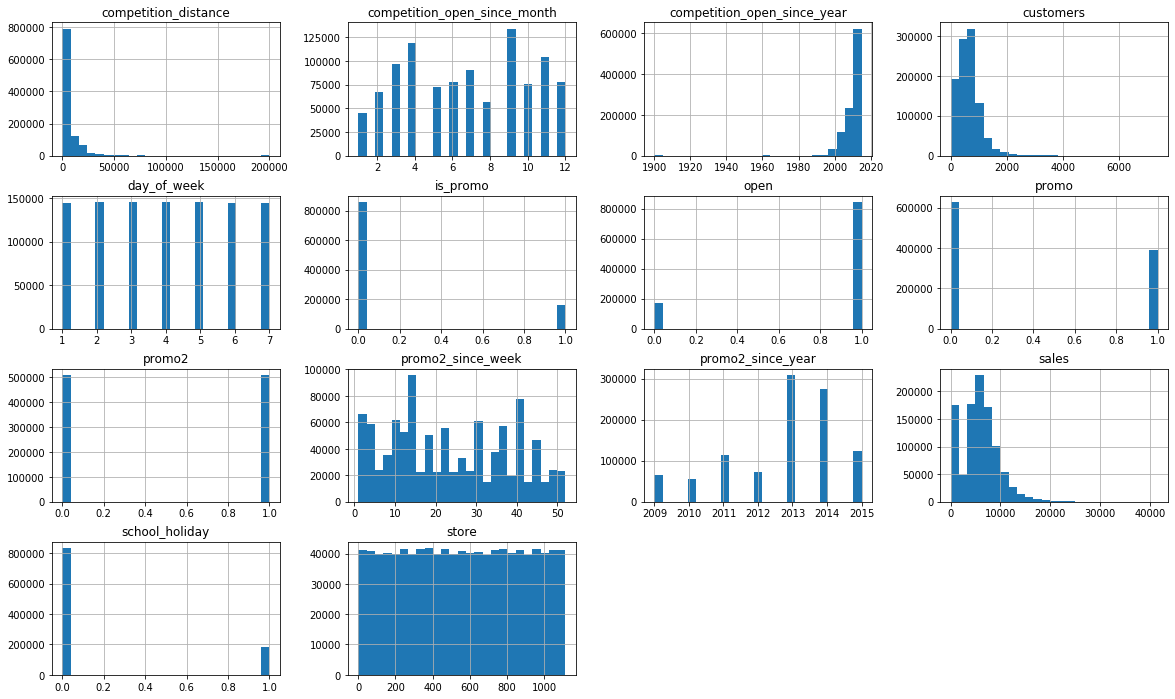

In [31]:
num_attributes.hist(bins = 25, figsize=(20,12));

Entendimento de cada gráfico:
- store
- day_of_week(Dias da semana, numero de vendas) = Não ha uma grande diferença de vendas nos dias da semana, praticamente possuem o mesmo comportamento, não importa o dia. 

- sales
- customers
- open
- promo
- school_holiday

- competition_distance(distancia da loja para os competidores) = O gráfico possui uma grande concentração nas distâncias menores, indicando que a maioria das lojas possuem competidores próximos.

- competition_open_since_month(lojas competidoras aberas a quantos meses) = temos um comportamento de bastante lojas competidoras abrindo no mês 4, depois a uma queda, voltando a ter muitas lojas abertas no mes 9.

- promo2_since_week
- promo2_since_year
- is_promo
- competition_open_since_year
- promo2


In [32]:
num_attributes

,store,day_of_week,sales,customers,open,promo,school_holiday,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,is_promo
0,1,5,5263,555,1,1,1,1270.0,9,2008,0,31,2015,0
1,2,5,6064,625,1,1,1,570.0,11,2007,1,13,2010,1
2,3,5,8314,821,1,1,1,14130.0,12,2006,1,14,2011,1
3,4,5,13995,1498,1,1,1,620.0,9,2009,0,31,2015,0
4,5,5,4822,559,1,1,1,29910.0,4,2015,0,31,2015,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1017204,1111,2,0,0,0,0,1,1900.0,6,2014,1,31,2013,1
1017205,1112,2,0,0,0,0,1,1880.0,4,2006,0,1,2013,0
1017206,1113,2,0,0,0,0,1,9260.0,1,2013,0,1,2013,0
1017207,1114,2,0,0,0,0,1,870.0,1,2013,0,1,2013,0


### 4.1.3. Categorical Variable

In [33]:
df4['state_holiday'].drop_duplicates()

0            regular_day
63559     public holiday
129424    Easter holiday
241126         Christmas
Name: state_holiday, dtype: object

In [34]:
df4['store_type'].drop_duplicates()

0     c
1     a
12    d
84    b
Name: store_type, dtype: object

In [35]:
df4['assortment'].drop_duplicates()

0         basic
3      extended
258       extra
Name: assortment, dtype: object

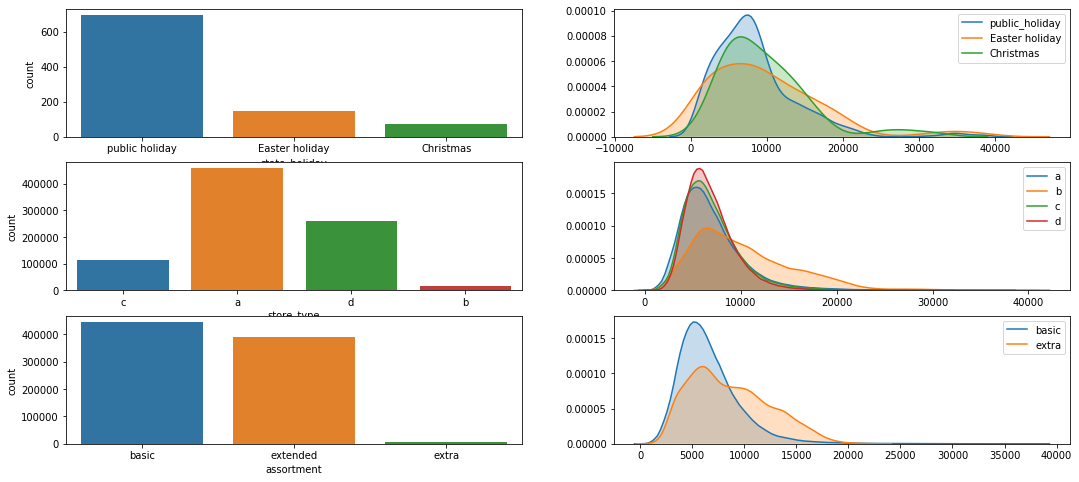

In [36]:
# state_holiday
plt.subplot( 3, 2, 1)
a = df4[df4['state_holiday'] != 'regular_day']
sns.countplot( a['state_holiday'] ).figure.set_size_inches(15,8);

plt.subplot( 3, 2, 2)
sns.kdeplot( df4[df4['state_holiday']== 'public holiday']['sales'],  label='public_holiday', shade=True )
sns.kdeplot( df4[df4['state_holiday']== 'Easter holiday']['sales'], label='Easter holiday', shade=True )
sns.kdeplot( df4[df4['state_holiday']== 'Christmas']['sales'],  label='Christmas', shade=True )
plt.legend()

# store_type
plt.subplot( 3, 2, 3)
sns.countplot( df4['store_type'] ).figure.set_size_inches(18,8);

plt.subplot( 3, 2, 4)
sns.kdeplot( df4[df4['store_type']== 'a']['sales'],  label='a', shade=True )
sns.kdeplot( df4[df4['store_type']== 'b']['sales'], label='b', shade=True )
sns.kdeplot( df4[df4['store_type']== 'c']['sales'],  label='c', shade=True )
sns.kdeplot( df4[df4['store_type']== 'd']['sales'],  label='d', shade=True )
plt.legend()


# assortment
plt.subplot( 3, 2, 5)
sns.countplot( df4['assortment'] ).figure.set_size_inches(18,8);

plt.subplot( 3, 2, 6)
sns.kdeplot( df4[df4['assortment']== 'basic']['sales'],  label='basic', shade=True )
sns.kdeplot( df4[df4['assortment']== 'extend']['sales'], label='extend', shade=True )
sns.kdeplot( df4[df4['assortment']== 'extra']['sales'],  label='extra', shade=True )
plt.legend()

## 4.2. Analise Bivariada

Na analise Bivariada, onde estudamos o impacto de uma variável com relação a nossa variável resposta. 

### **H1.** Lojas com maior sortimentos deveriam vender mais.
**FALSA** Lojas com maior MAIOR SORTIMENTO vendem MENOS


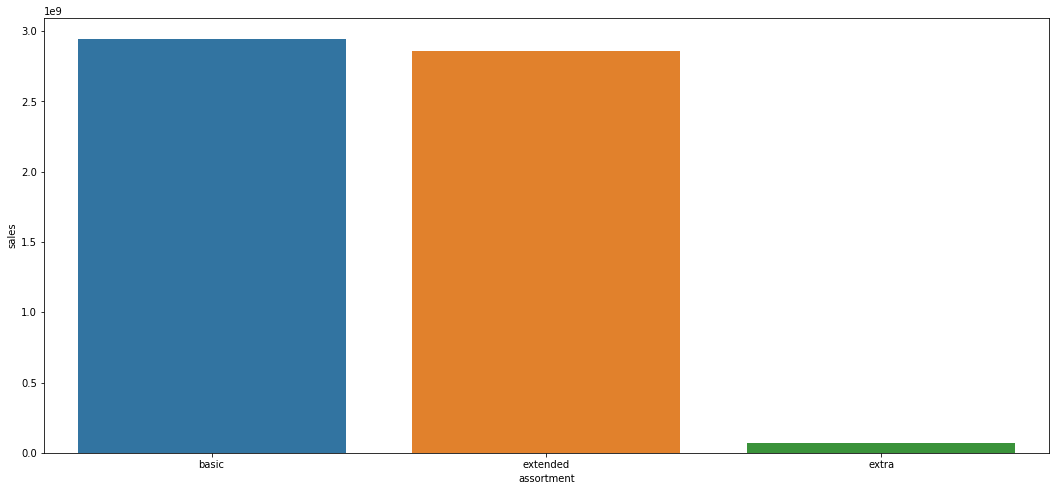

In [37]:
aux1 = df4[['assortment','sales']].groupby('assortment').sum().reset_index()
sns.barplot( x='assortment', y = 'sales', data = aux1).figure.set_size_inches(18,8);

In [38]:
aux1


,assortment,sales
0,basic,2945750070
1,extended,2856484241
2,extra,70946312


> Vemos numa primeira observação que na verdade ao contrário, quando maior o assortment, no caso o 'extra', vende menos do que as com do tipo 'basic' ou 'extend'. 

> Para podermos investigar um pouco mais a seguir iremos incluir a variável tempo, para ver qual foi o comportament ao longo do tempo para cada tipo de assortment. 

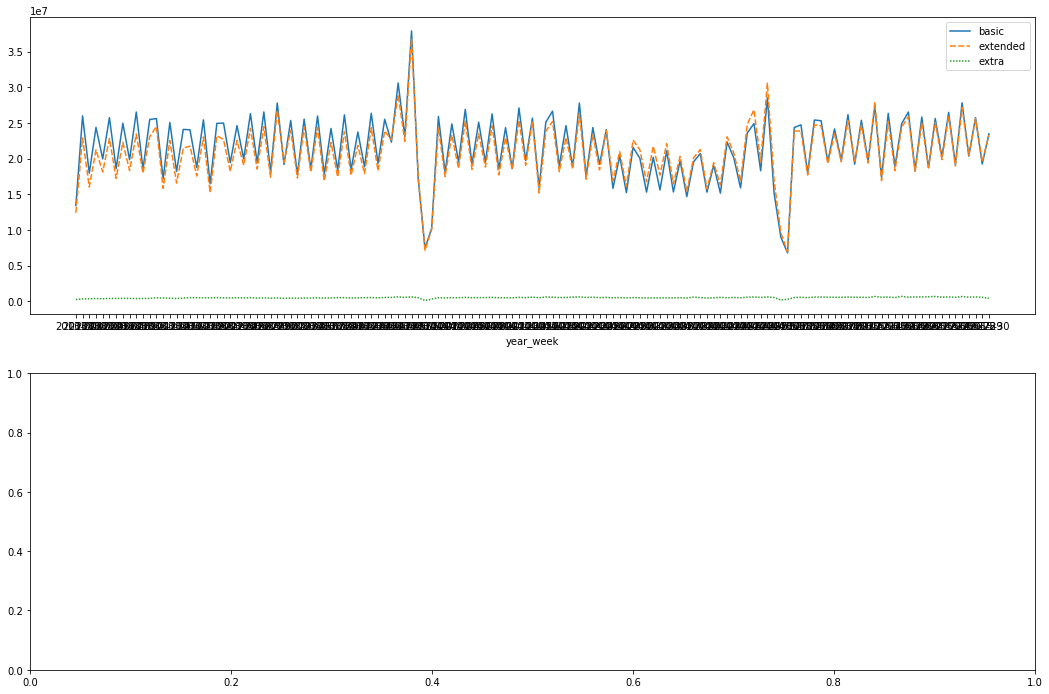

In [39]:
#plot assortment year_week:

aux2 = df4[['year_week', 'assortment','sales']].groupby( ['year_week','assortment'] ).sum().reset_index()
plot_aux2 = aux2.pivot( index= 'year_week', columns='assortment', values = 'sales')
plt.subplot( 2, 1, 1)
sns.lineplot( data=plot_aux2  ).figure.set_size_inches(18,12);


#Plot assortment extra year_week:
aux3 = aux2[aux2['assortment'] == 'extra']
plt.subplot( 2, 1, 2)
#sns.lineplot( data=aux3  ).figure.set_size_inches(18,12);


> Mesmo ao longo do tempo, as logas do assortment extra vendem bem menos. Assim podemos considerar a hipotese FALSA

#### h1.2 Considerando a média

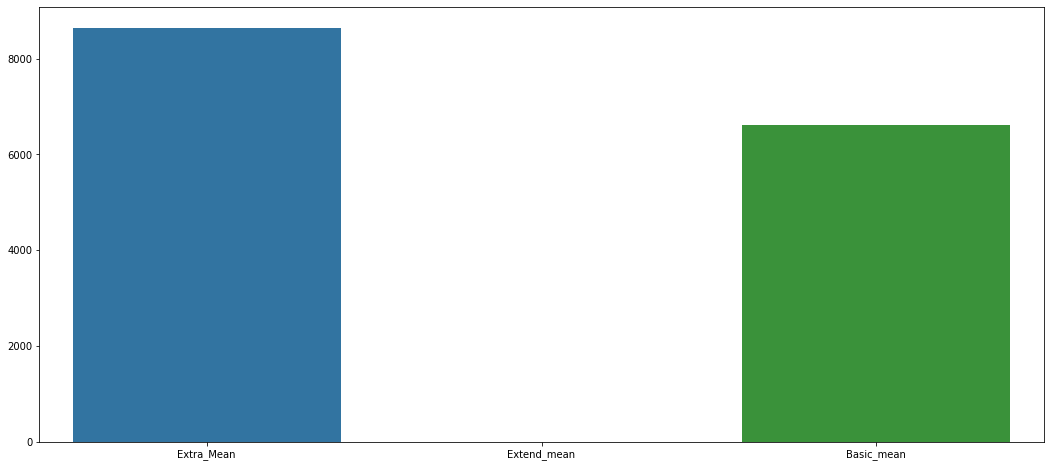

In [40]:
#Na minha visão deveria ser feito com a média, ai ficaria algo do tipo:
media_assortment_extra = round(df4['sales'][df4['assortment'] == 'extra'].mean(), 2)
media_assortment_extend = round(df4['sales'][df4['assortment'] == 'extend'].mean(), 2)
media_assortment_basic = round(df4['sales'][df4['assortment'] == 'basic'].mean(), 2)

d = {'Extra_Mean': [media_assortment_extra], 'Extend_mean': [media_assortment_extend], 'Basic_mean': [media_assortment_basic] }
df_assortment_mean = pd.DataFrame(data=d)
sns.barplot( data = df_assortment_mean ).figure.set_size_inches(18,8);

In [41]:
print('Numero de lojas assortment do tipo extra: ', df4['sales'][df4['assortment'] == 'extra'].shape[0]) 
print('Numero de lojas assortment do tipo extend: ', df4['sales'][df4['assortment'] == 'extend'].shape[0])
print('Numero de lojas assortment do tipo basic: ', df4['sales'][df4['assortment'] == 'basic'].shape[0])

Numero de lojas assortment do tipo extra:  8209
Numero de lojas assortment do tipo extend:  0
Numero de lojas assortment do tipo basic:  444875


### **H2.** Lojas com competidores mais próximos deveriam vender menos.
**FALSA** Lojas com COMPETIDORES MAIS PRÓXIMOS vendem MAIS


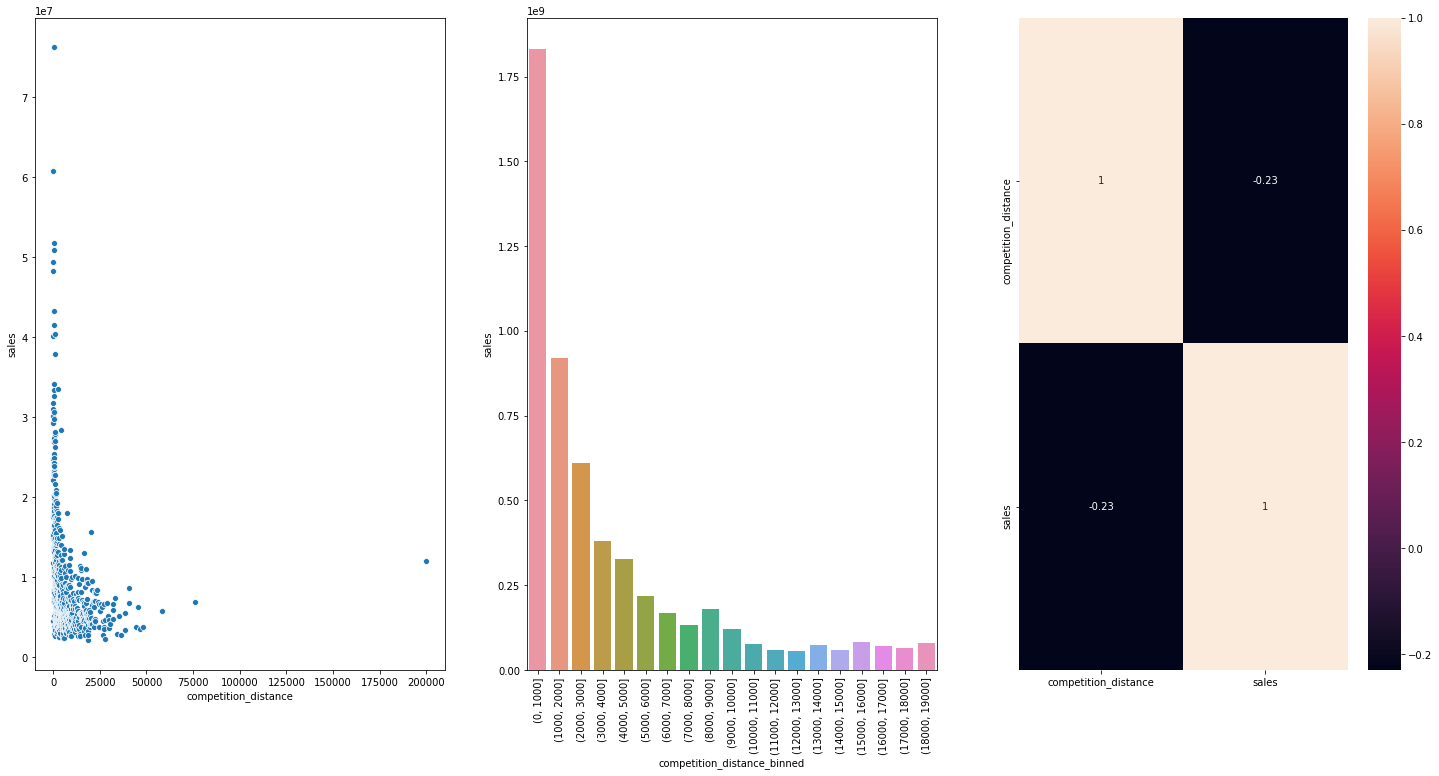

In [42]:
aux1 = df4[['competition_distance', 'sales']].groupby( 'competition_distance' ).sum().reset_index()

plt.subplot( 1, 3, 1).figure.set_size_inches(25,12)
sns.scatterplot( x = 'competition_distance', y = 'sales', data = aux1 );

bins = list( np.arange( 0, 20000, 1000)  )

aux1[ 'competition_distance_binned' ] = pd.cut( aux1['competition_distance'], bins = bins )
aux2 = aux1[['competition_distance_binned', 'sales']].groupby( 'competition_distance_binned' ).sum().reset_index()
plt.subplot( 1, 3, 2)
sns.barplot( x='competition_distance_binned', y='sales', data=aux2 );
plt.xticks( rotation = 90 );

plt.subplot( 1, 3, 3 )
sns.heatmap( aux1.corr( method='pearson' ), annot = True);

> Nesta hipótese percebemos que a uma maior concentração no número de vendas quando a distância é menor. Na matriz de correlação temos inclusive uma correlação negatia, assim mais uma vez nossa hipótese é falsa. 

### **H3.** Lojas com competidores à mais tempo deveriam vender mais.
**FALSE** Lojas com COMPETIDORES À MAIS TEMPO vendem MENOS. 

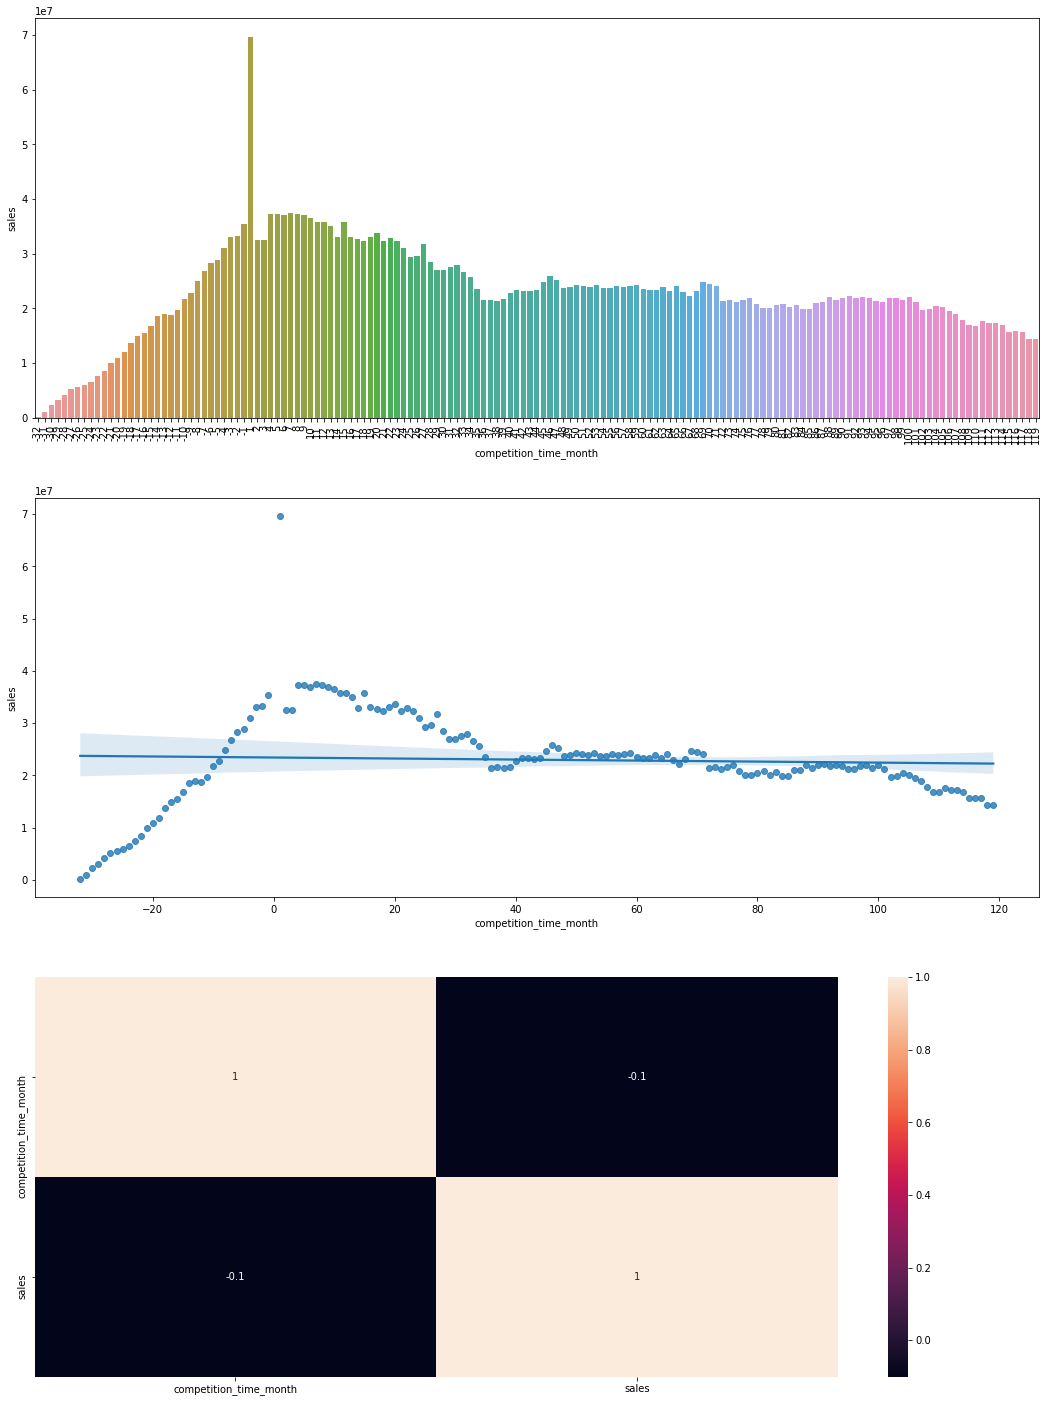

In [43]:
aux1 = df4[['competition_time_month', 'sales']].groupby( 'competition_time_month' ).sum().reset_index()
aux2 = aux1[(aux1['competition_time_month'] < 120 ) & (aux1['competition_time_month' ]!= 0 ) ]

plt.subplot( 3, 1, 1).figure.set_size_inches(18,25);
sns.barplot( x = 'competition_time_month', y = 'sales', data = aux2)
plt.xticks( rotation = 90 );

plt.subplot( 3, 1, 2)
sns.regplot( x = 'competition_time_month', y = 'sales', data = aux2)

plt.subplot(3, 1, 3)
x = sns.heatmap( aux1.corr( method = 'pearson'), annot= True );

> A hipótese esta desvalidada, pois vemos que mesmo que com pouco tempo de abertura a venda caia, no decorrer do tempo se estabiliza as vendas. Inclusive a uma correlação negativa, indicando que com o decorrer do tempo de abertura de competidores próximos a um decaimento nas vendas. 

### **H4.** Lojas com promoção ativas por mais tempo deveriam vender mais. 
**FALSA** Lojas com PROMOÇÕES ATIVAS POR MAIS TEMPO, depois de um certo periodo de promoção

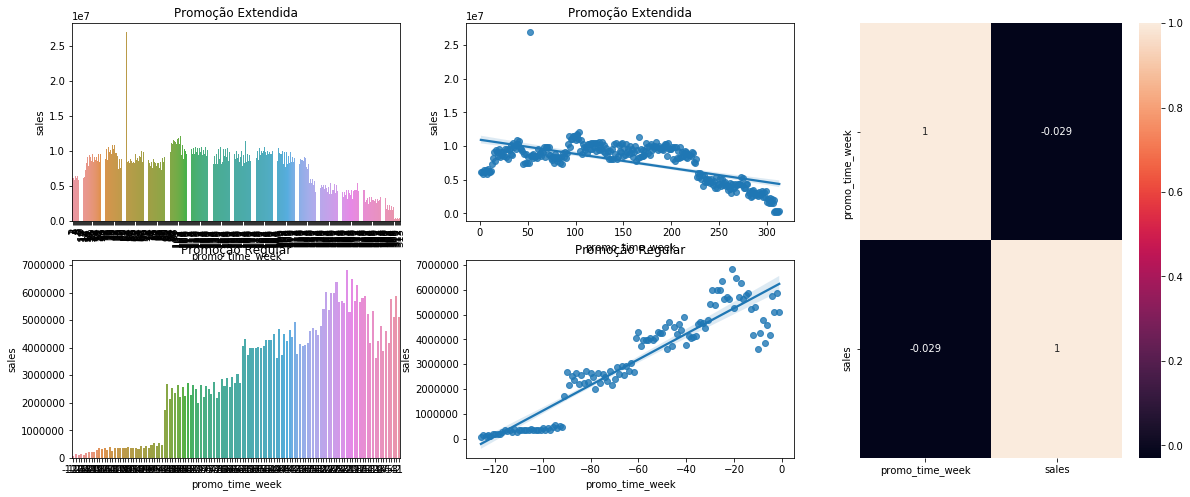

In [44]:
aux1 = df4[['promo_time_week', 'sales']].groupby( 'promo_time_week' ).sum().reset_index()

grid = gdc.GridSpec( 2, 3 )

#plot promo extendido
aux2 = aux1[aux1['promo_time_week'] > 0 ]
plt.subplot( grid[0, 0]).figure.set_size_inches(20,8)
sns.barplot( x='promo_time_week', y= 'sales', data=aux2 ).set_title('Promoção Extendida');
plt.xticks( rotation = 90 );

plt.subplot(grid[0, 1])
sns.regplot( x='promo_time_week', y= 'sales', data=aux2 ).set_title('Promoção Extendida');

#Plot promo regular
aux3 = aux1[aux1['promo_time_week'] < 0 ]
plt.subplot(grid[1, 0])
sns.barplot( x='promo_time_week', y= 'sales', data=aux3 ).set_title('Promoção Regular');

plt.subplot(grid[1, 1])
sns.regplot( x='promo_time_week', y= 'sales', data=aux3 ).set_title('Promoção Regular');

plt.subplot(grid[:,2])
sns.heatmap( aux1.corr( method= 'pearson'), annot = True  );

> Podemos analisar pelos gráficos que a um decaimento nas vendas depois de um tempo em promoção. Assom, podemos regutar que as vendas sobem conforme o tempo de promoção. 

> Ao analisar a correlação, esta feature exerce uma correlação bem baixa. 

### <S>**H5.** Lojas com mais dias de promoção deveriam vender mais.


IREMOS VALIDAR ELA NO PRÓXIMO CICLO DO CRISP

### **H6.** Lojas com mais promoção consecutivas deveriam vender mais. 
**FALSA** Lojas com MAIS PROMOÇÃO CONSECUTIVAS vendem MENOS.

In [45]:
df4[['promo', 'promo2', 'sales']].groupby( ['promo', 'promo2'] ).sum().reset_index()

,promo,promo2,sales
0,0,0,1482612096
1,0,1,1289362241
2,1,0,1628930532
3,1,1,1472275754


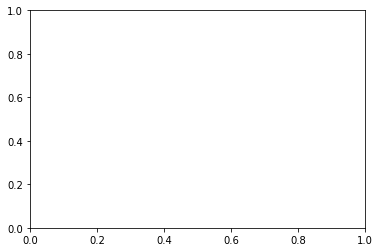

In [46]:
# Lojas com Promo tradicional e extendida:
aux1 = df4[(df4['promo'] == 1 ) & ( df4['promo2'] == 1 )][['year_week', 'sales']].groupby('year_week').sum().reset_index()



# Lojas que só participaram da tradicional:
aux2 = df4[(df4['promo'] == 1 ) & ( df4['promo2'] == 0 )][['year_week', 'sales']].groupby('year_week').sum().reset_index()

fig, ax = plt.subplots()
#sns.lineplot(data=aux1, label = 'extendida').figure.set_size_inches(20,8);
#sns.lineplot(data=aux2, palette=['r'], label = 'tradicional');

> Ao compararmos os gráficos da promoção extendida para promo2 tiveram queda nas vendas, logo podemos refutar a hipótese. 

### **H7.** Lojas abertas durante o feriado de Natal deveriam vender mais.
**FALSA** Lojas abertas durante o feriado do Natal vendm menos. 

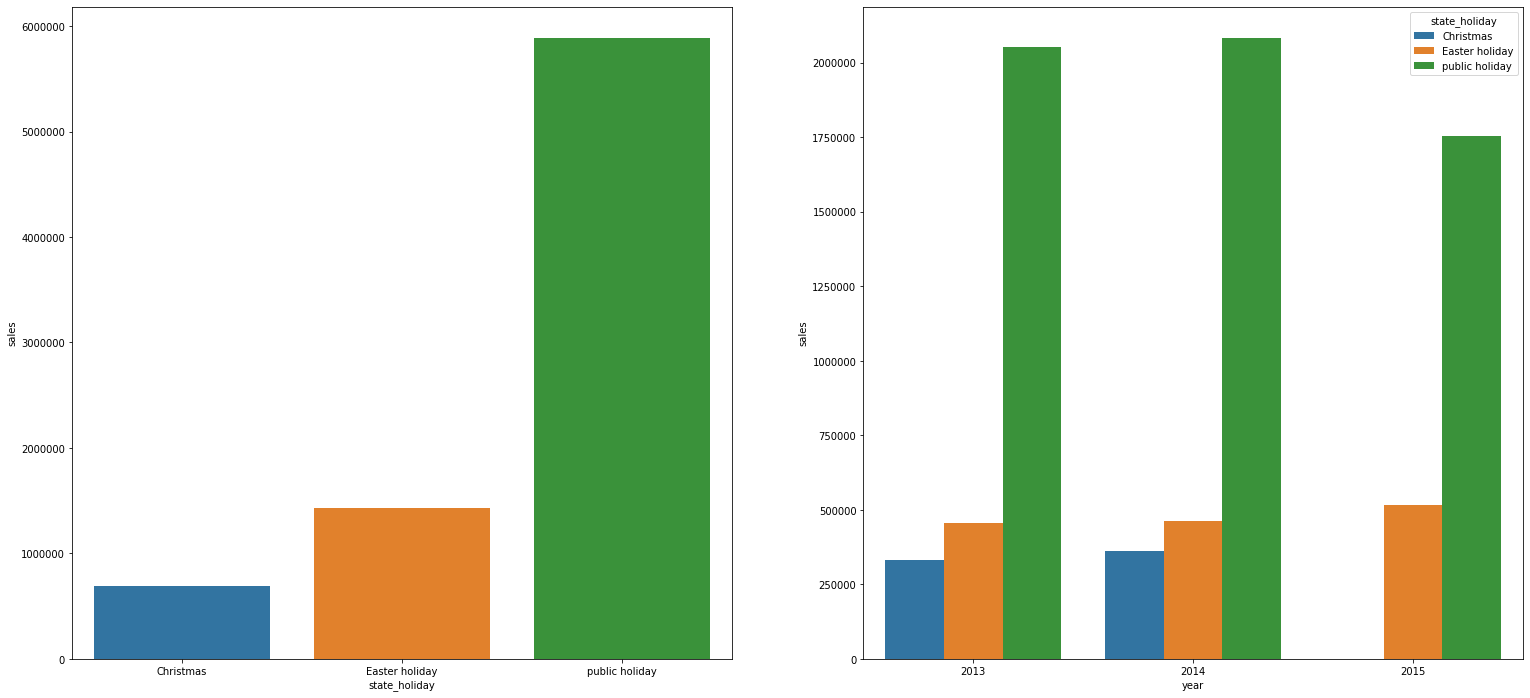

In [47]:
aux = df4[df4['state_holiday'] != 'regular_day']
aux1 = aux[['state_holiday', 'sales']].groupby( 'state_holiday' ).sum().reset_index()
plt.subplot( 1, 2, 1).figure.set_size_inches(26,12);
sns.barplot( x = 'state_holiday', y = 'sales', data = aux1 );

aux2 = aux[['year', 'state_holiday', 'sales', ]].groupby( ['year', 'state_holiday'] ).sum().reset_index()
plt.subplot( 1, 2, 2);
sns.barplot( x = 'year', y = 'sales', hue='state_holiday', data = aux2 );

> Apoós plotar os gráficos com as vendas durante os feriados, vemos que tanto no total, como na comparação ano ano, não houve uma venda superior durante os feriados de natal. 

### **H8.** Lojas deveriam vender mais ao longo dos anos.
**FALSA** Lojas vendem menos ao longo dos anos

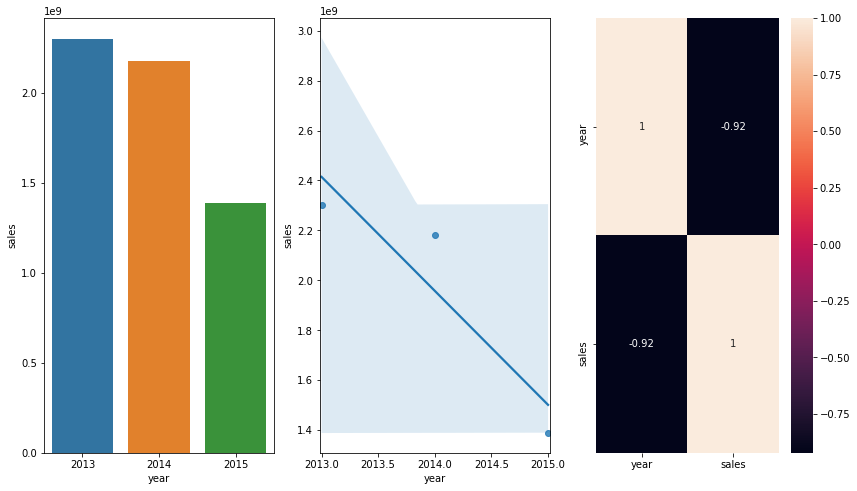

In [48]:
aux1 = df4[['year', 'sales']].groupby( 'year' ).sum().reset_index()

plt.subplot(1,3,1).figure.set_size_inches(14,8)
sns.barplot( x='year', y = 'sales', data= aux1);

plt.subplot(1,3,2)
sns.regplot( x='year', y = 'sales', data= aux1);

plt.subplot(1,3, 3)
sns.heatmap( aux1.corr( method = 'pearson' ), annot = True );

> Vemos uma temdência de queda durante os anos nas vendas. Lembrando que esta forte correlação aconteceu porque temos o ano de 2015 sem estar fechado, assim para correlação de venda ao longo dos anos deveriamos tirar o ano de 2015. 

### **H9.** Lojas deveriam vender mais no segundo semestre do ano.
**FALSA** Lojas vendem menos no segundo semestre do ano

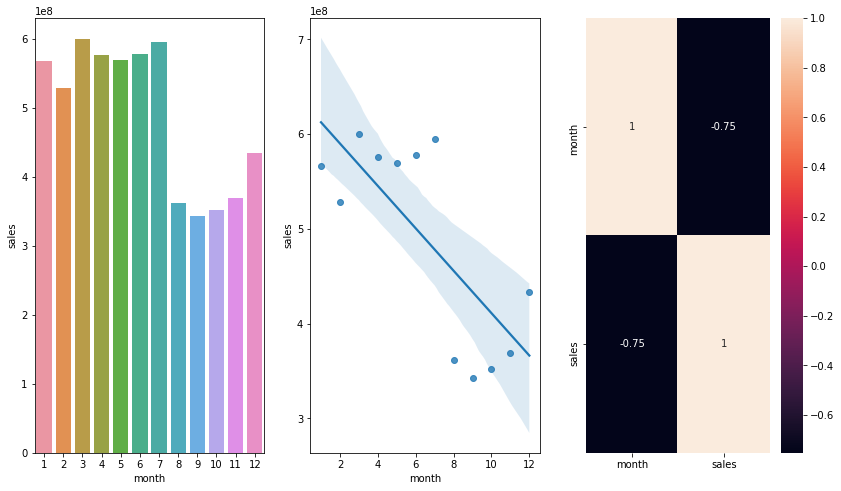

In [49]:
aux1 = df4[['month', 'sales']].groupby( 'month' ).sum().reset_index()

plt.subplot(1,3,1).figure.set_size_inches(14,8)
sns.barplot( x='month', y = 'sales', data= aux1);

plt.subplot(1,3,2)
sns.regplot( x='month', y = 'sales', data= aux1);

plt.subplot(1,3, 3)
sns.heatmap( aux1.corr( method = 'pearson' ), annot = True );

> Ao contrario do que levantamos na hipotese, temos um grande caimento das vendas no segundo semestre. E também temos uma forte correlação negativa. 

### **10.** Lojas deveriam vender mais depois do dia 10 de cada mês.
**VERDADEIRA** Lojas vendem mais depois do dia 10 de cada mês.

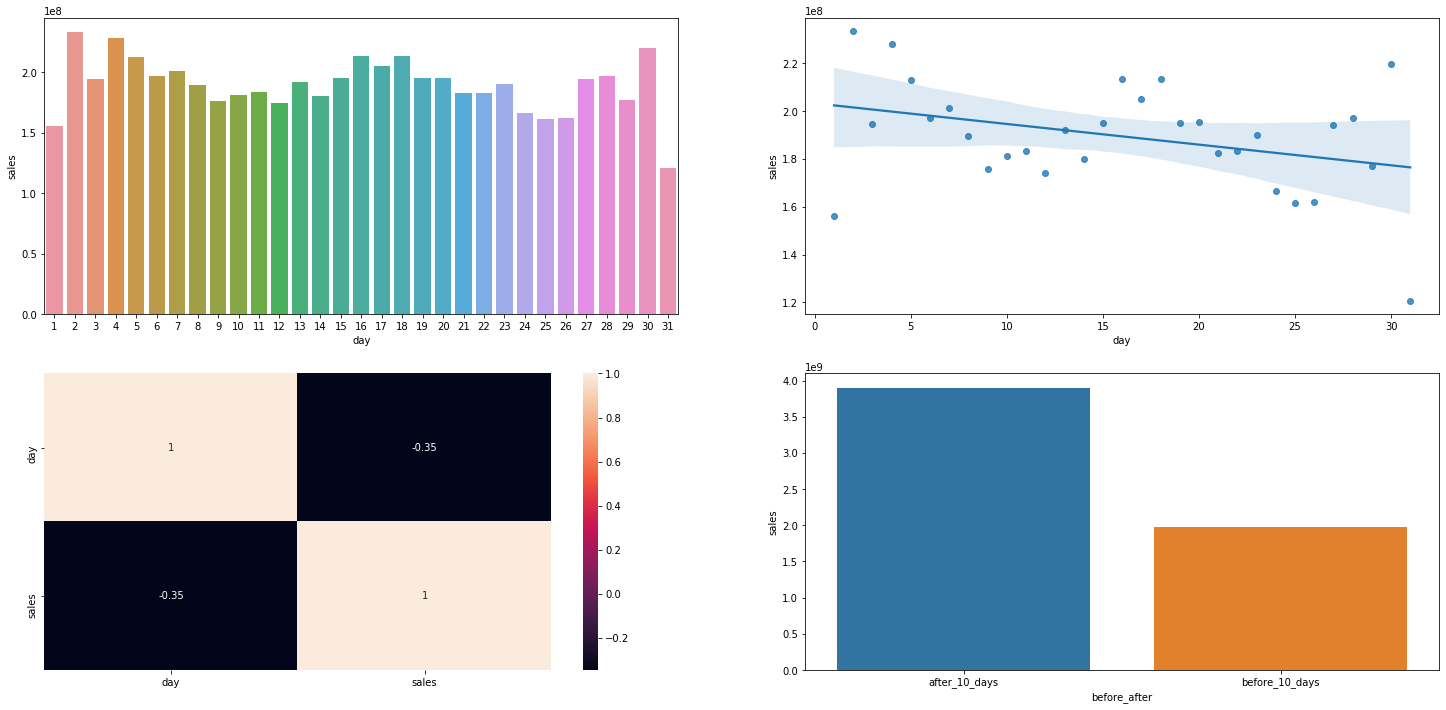

In [50]:
aux1 = df4[['day', 'sales']].groupby( 'day' ).sum().reset_index()

plt.subplot(2,2,1).figure.set_size_inches(25,12)
sns.barplot( x='day', y = 'sales', data= aux1);

plt.subplot(2,2,2)
sns.regplot( x='day', y = 'sales', data= aux1);

plt.subplot(2,2, 3)
sns.heatmap( aux1.corr( method = 'pearson' ), annot = True );

aux1['before_after'] = aux1['day'].apply( lambda x: 'before_10_days' if x <= 10 else 'after_10_days')
aux2= aux1[['before_after', 'sales']].groupby( 'before_after' ).sum().reset_index()

plt.subplot(2,2, 4)
sns.barplot( x='before_after', y= 'sales', data= aux2);

> Não observamos um ganho ou queda muito claro após o dia 10, havendo variações não tão lineares. Ao compararmos as vendas até o dia 10 e nos outros 20 dias após, vemos que temos uma relação muito próxima de 2 pra 1, o que pode ser explicado que o somatório dos dias após o dia 10 é o dobro de dia, 20 para 10. 

### **11.** Lojas deveriam vender menos aos finais de semana.
**VERDADEIRA** Lojas vendem nenos nos finais de semana

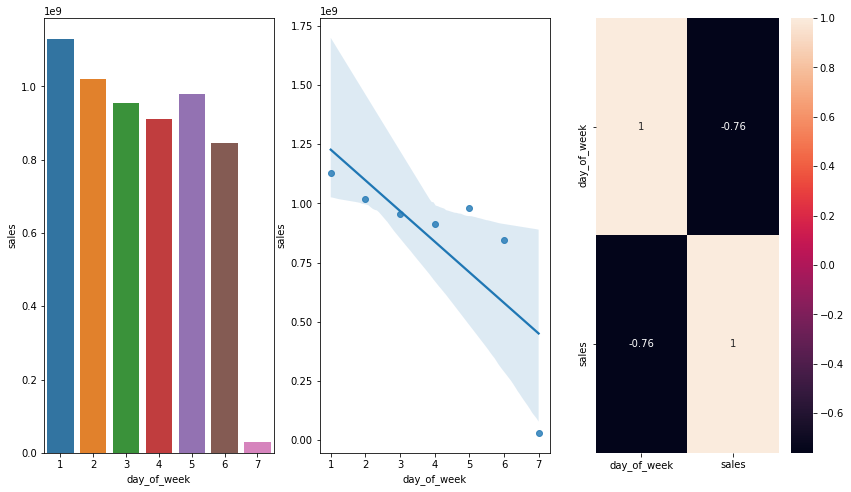

In [51]:
aux1 = df4[['day_of_week', 'sales']].groupby( 'day_of_week' ).sum().reset_index()

plt.subplot(1,3,1).figure.set_size_inches(14,8)
sns.barplot( x='day_of_week', y = 'sales', data= aux1);

plt.subplot(1,3,2)
sns.regplot( x='day_of_week', y = 'sales', data= aux1);

plt.subplot(1,3, 3)
sns.heatmap( aux1.corr( method = 'pearson' ), annot = True );

> A uma queda de venda ao longo da semana, final de semana é mais fraca as vendas. 

### **12.** Lojas deveriam vender menos durante os feriados escolares.
**VERDADEIRA** Lojas vendem menos durante os feriados escolares, exceto nos mêses de Julho e Agosto

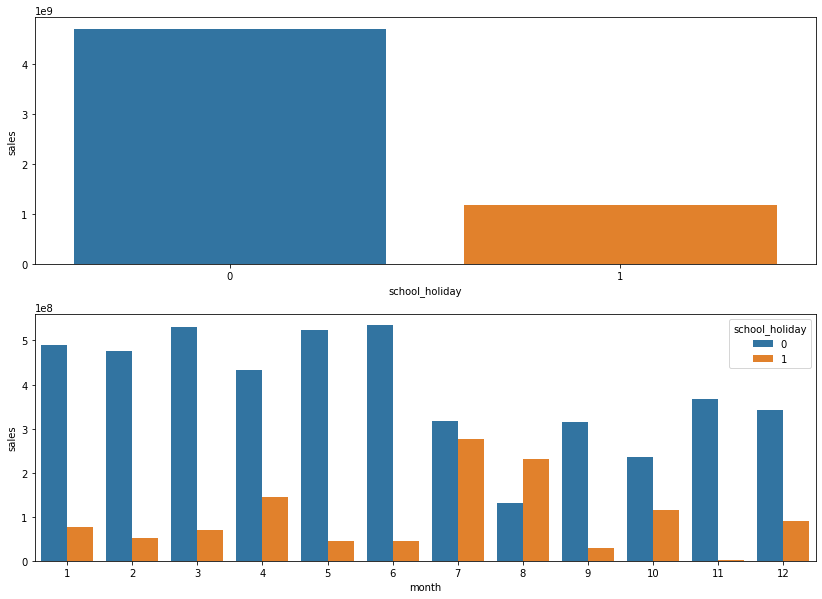

In [52]:
aux1 = df4[['school_holiday', 'sales']].groupby( 'school_holiday' ).sum().reset_index()

plt.subplot(2,1,1).figure.set_size_inches(14,10)
sns.barplot( x='school_holiday', y = 'sales', data= aux1);

aux2 = df4[['month', 'school_holiday', 'sales']].groupby( ['month', 'school_holiday'] ).sum().reset_index()
plt.subplot(2,1,2)
sns.barplot( x='month', y = 'sales', hue = 'school_holiday', data= aux2);

### 4.2.1 Resmo das Hipoteses

In [53]:
 tab =[['Hipoteses', 'Conclusao', 'Relevancia'],
['H1', 'Falsa', 'Baixa'],
['H2', 'Falsa', 'Media'],
['H3', 'Falsa', 'Media'],
['H4', 'Falsa', 'Baixa'],
['H5', '-', '-'],
['H6', 'Falsa', 'Baixa'],
['H7', 'Falsa', 'Media'],
['H8', 'Falsa', 'Alta'],
['H9', 'Falsa', 'Alta'],
['H10', 'Verdadeira', 'Alta'],
['H11', 'Verdadeira', 'Alta'],
['H12', 'Verdadeira', 'Baixa'],
]
print( tabulate( tab, headers='firstrow' ) )

Hipoteses    Conclusao    Relevancia
-----------  -----------  ------------
H1           Falsa        Baixa
H2           Falsa        Media
H3           Falsa        Media
H4           Falsa        Baixa
H5           -            -
H6           Falsa        Baixa
H7           Falsa        Media
H8           Falsa        Alta
H9           Falsa        Alta
H10          Verdadeira   Alta
H11          Verdadeira   Alta
H12          Verdadeira   Baixa


## 4.3. Analise Multivariada

Na analise Multivariada, cujo o objetivo é encontrar a correlação não apenas em relação a variável resposta mas também entre elas. 

### 4.3.1. Numerical Attrubutes

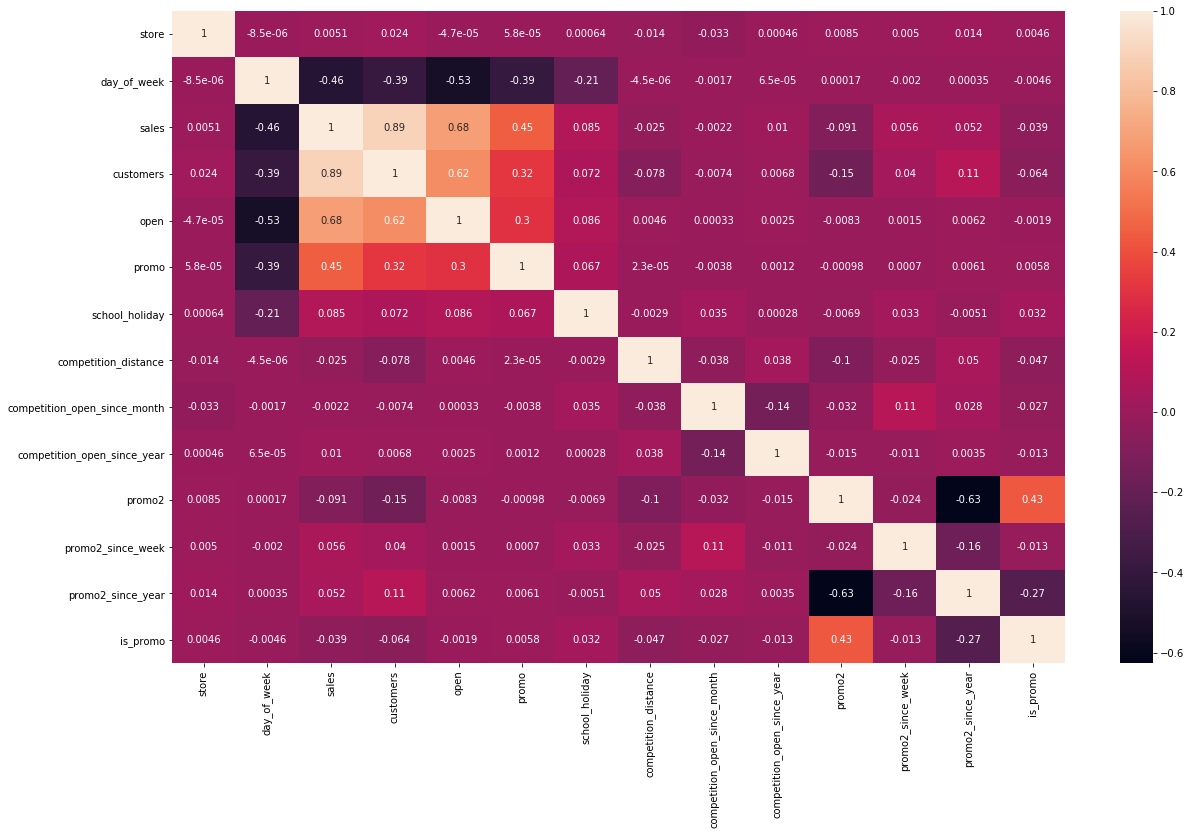

In [54]:
correlation = num_attributes.corr( method = 'pearson' )
sns.heatmap( correlation, annot = True ).figure.set_size_inches(20,12);

### 4.3.2. Categorical Attributes

No caso da categórica não podemos usar o método Pearson usado nas númericas. Logo usaremos aqui o método de cramer V. 

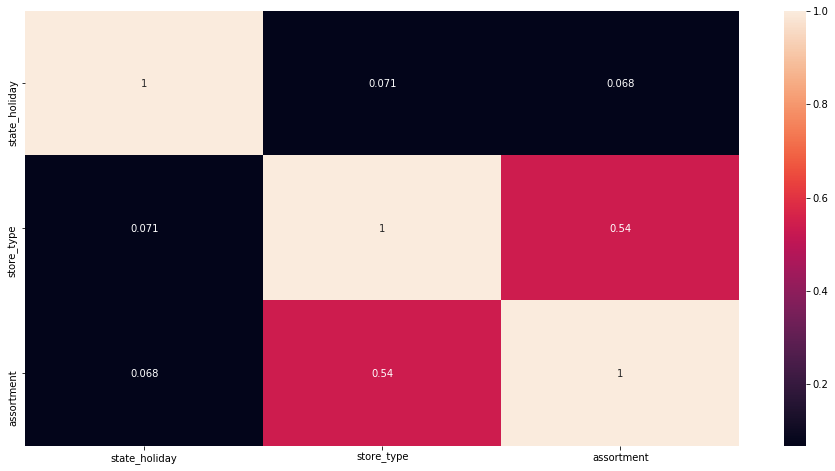

In [55]:
#only categorical_data
a= df4.select_dtypes( include='object' )


#Calculate Cramer V
a1 = cramer_v( a['state_holiday'], a['state_holiday'] )
a2 = cramer_v( a['state_holiday'], a['store_type'] )
a3 = cramer_v( a['state_holiday'], a['assortment'] )


a4 = cramer_v( a['store_type'], a['state_holiday'] )
a5 = cramer_v( a['store_type'], a['store_type'] )
a6 = cramer_v( a['store_type'], a['assortment'] )


a7 = cramer_v( a['assortment'], a['state_holiday'] )
a8 = cramer_v( a['assortment'], a['store_type'] )
a9 = cramer_v( a['assortment'], a['assortment'] )

#Final dataset
d = pd.DataFrame( {'state_holiday': [a1, a2, a3], 
               'store_type': [a4, a5, a6], 
               'assortment': [a7, a8, a9] })
d = d.set_index( d.columns )

#Plot heatmap correlaction:
sns.heatmap( d, annot=True ).figure.set_size_inches(16,8);

# 5.0. DATA PREPARATION

In [56]:
df5 = df4.copy()

## 5.1. Normalização

Ao analisar as variáveis na cessão '4.1.2 Numerical Variable', vemos que as variáveis númericas do nosso projéto não obedecem comportamento com características de uma Normal, logo não iremos usar Normalização em nenhuma destas. 

## 5.2. Rescaling

In [57]:
a = df5.select_dtypes( include=['int64', 'float64'] )

In [58]:
# A função RobustScaler(), transforma os valores para uma mesma escala usando os quartis no calculo
# É mais usada nos casos de variáveis que possuem outliers com valores elevados. 
rs = RobustScaler()
rms = MinMaxScaler()

# competition distance
df5['competition_distance' ]= rs.fit_transform( df5[['competition_distance']].values )

# competition time month
df5['competition_time_month' ]= rs.fit_transform( df5[['competition_time_month']].values )

# promo time week 
df5['promo_time_week' ]= rms.fit_transform( df5[['promo_time_week']].values )

# year
df5['year']= rms.fit_transform( df5[['year']].values )



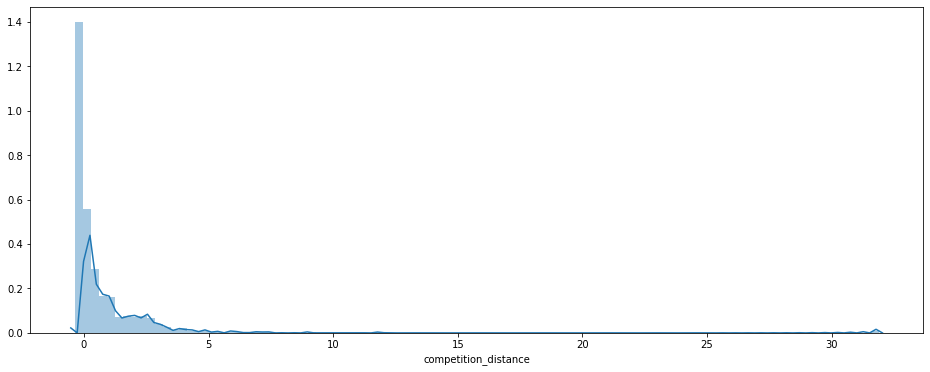

In [59]:
sns.distplot( df5['competition_distance'], bins = 100).figure.set_size_inches(16,6);

In [60]:
df5['competition_distance']

0         -0.170968
1         -0.283871
2          1.903226
3         -0.275806
4          4.448387
             ...   
1016776   -0.351613
1016827   -0.237097
1016863   -0.240323
1017042   -0.145161
1017190   -0.259677
Name: competition_distance, Length: 844338, dtype: float64

> Foi usado o RobustScaler() nas variaveis: competition_distance e competition_time_month pois ao plotar ficou claro a presença de outiliers com valores muito elevados, como a RobustScaler(), transforma os valores para uma mesma escala usando os quartis no calculo é mais indicada para variáveis que possuem grandes desvios nos outiliers, pois na fórmula por não considerar a media e valores máximo e minimo como o MinMaxScaler faz, ele minimiza este efeito dos outiliers

> Foi usado o MinMaxScaler() nas variáveis: Promo_time_week e year, pois os valores dos outliers não são tão altos, neste tipo de caso ela é o mais indicado 


## 5.3. Transformação

### 5.3.1 Econding

In [61]:
df5.head(5)

,store,day_of_week,date,sales,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,...,is_promo,year,month,day,week_of_year,year_week,competition_since,competition_time_month,promo_since,promo_time_week
0,1,5,2015-07-31,5263,1,regular_day,1,c,basic,-0.170968,...,0,1.0,7,31,31,2015-30,2008-09-01,0.918919,2015-07-27,0.287016
1,2,5,2015-07-31,6064,1,regular_day,1,a,basic,-0.283871,...,1,1.0,7,31,31,2015-30,2007-11-01,1.054054,2010-03-22,0.922551
2,3,5,2015-07-31,8314,1,regular_day,1,a,basic,1.903226,...,1,1.0,7,31,31,2015-30,2006-12-01,1.202703,2011-03-28,0.801822
3,4,5,2015-07-31,13995,1,regular_day,1,c,extended,-0.275806,...,0,1.0,7,31,31,2015-30,2009-09-01,0.743243,2015-07-27,0.287016
4,5,5,2015-07-31,4822,1,regular_day,1,a,basic,4.448387,...,0,1.0,7,31,31,2015-30,2015-04-01,-0.162162,2015-07-27,0.287016


In [62]:
# state_holiday
#usaremos o 'on hot encoding' 
df5 = pd.get_dummies( df5, prefix=['state_holiday'], columns = ['state_holiday'] )


# store_type
#usatemos a 'label encoding'
le = LabelEncoder()
df5['store_type'] = le.fit_transform( df5['store_type'])

#assortment
#usaremos o encoding 'ordinal encoding'
assortment_dict = {'basic': 1, 
                  'extra':2, 
                  'extended': 3}
df5['assortment'] = df5['assortment'].map( assortment_dict )
df5.head()

,store,day_of_week,date,sales,promo,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,...,week_of_year,year_week,competition_since,competition_time_month,promo_since,promo_time_week,state_holiday_Christmas,state_holiday_Easter holiday,state_holiday_public holiday,state_holiday_regular_day
0,1,5,2015-07-31,5263,1,1,2,1,-0.170968,9,...,31,2015-30,2008-09-01,0.918919,2015-07-27,0.287016,0,0,0,1
1,2,5,2015-07-31,6064,1,1,0,1,-0.283871,11,...,31,2015-30,2007-11-01,1.054054,2010-03-22,0.922551,0,0,0,1
2,3,5,2015-07-31,8314,1,1,0,1,1.903226,12,...,31,2015-30,2006-12-01,1.202703,2011-03-28,0.801822,0,0,0,1
3,4,5,2015-07-31,13995,1,1,2,3,-0.275806,9,...,31,2015-30,2009-09-01,0.743243,2015-07-27,0.287016,0,0,0,1
4,5,5,2015-07-31,4822,1,1,0,1,4.448387,4,...,31,2015-30,2015-04-01,-0.162162,2015-07-27,0.287016,0,0,0,1


### 5.3.2. Response Variable Transformation

In [63]:
# sales
df5['sales'] = np.log1p( df5['sales'] )
#sns.displot(data= df5['sales'], kde=True, bins=80).figure.set_size_inches(16,6);

### 5.3.3 Nature Transformation

In [64]:
# Vaiaveis com natureza ciclica
# day of week
df5['day_of_week_sin'] = df5['day_of_week'].apply( lambda x: np.sin( x * (2. * np.pi/7 ) ) )
df5['day_of_week_cos'] = df5['day_of_week'].apply( lambda x: np.cos( x * (2. * np.pi/7 ) ) )

# month
df5['month_sin'] = df5['month'].apply( lambda x: np.sin( x * (2. * np.pi/12 ) ) )
df5['month_cos'] = df5['month'].apply( lambda x: np.cos( x * (2. * np.pi/12 ) ) )

# day 
df5['day_sin'] = df5['day'].apply( lambda x: np.sin( x * (2. * np.pi/30 ) ) )
df5['day_cos'] = df5['day'].apply( lambda x: np.cos( x * (2. * np.pi/30 ) ) )

# week of year
df5['week_of_year_sin'] = df5['week_of_year'].apply( lambda x: np.sin( x * (2. * np.pi/52 ) ) )
df5['week_of_year_cos'] = df5['week_of_year'].apply( lambda x: np.cos( x * (2. * np.pi/52 ) ) )




In [65]:
df5

,store,day_of_week,date,sales,promo,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,...,state_holiday_public holiday,state_holiday_regular_day,day_of_week_sin,day_of_week_cos,month_sin,month_cos,day_sin,day_cos,week_of_year_sin,week_of_year_cos
0,1,5,2015-07-31,8.568646,1,1,2,1,-0.170968,9,...,0,1,-0.974928,-0.222521,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984
1,2,5,2015-07-31,8.710290,1,1,0,1,-0.283871,11,...,0,1,-0.974928,-0.222521,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984
2,3,5,2015-07-31,9.025816,1,1,0,1,1.903226,12,...,0,1,-0.974928,-0.222521,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984
3,4,5,2015-07-31,9.546527,1,1,2,3,-0.275806,9,...,0,1,-0.974928,-0.222521,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984
4,5,5,2015-07-31,8.481151,1,1,0,1,4.448387,4,...,0,1,-0.974928,-0.222521,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1016776,682,2,2013-01-01,8.124447,0,1,1,1,-0.351613,9,...,1,0,0.974928,-0.222521,0.5,0.866025,0.207912,0.978148,0.120537,0.992709
1016827,733,2,2013-01-01,9.284148,0,1,1,2,-0.237097,10,...,1,0,0.974928,-0.222521,0.5,0.866025,0.207912,0.978148,0.120537,0.992709
1016863,769,2,2013-01-01,8.524367,0,1,1,2,-0.240323,1,...,1,0,0.974928,-0.222521,0.5,0.866025,0.207912,0.978148,0.120537,0.992709
1017042,948,2,2013-01-01,8.410053,0,1,1,2,-0.145161,1,...,1,0,0.974928,-0.222521,0.5,0.866025,0.207912,0.978148,0.120537,0.992709


# 6.0. FEATURE SELECTION

In [66]:
df6 = df5.copy()

## 6.1. Split Dataframe Into Training an Test Dataset

In [67]:
df6.head()

,store,day_of_week,date,sales,promo,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,...,state_holiday_public holiday,state_holiday_regular_day,day_of_week_sin,day_of_week_cos,month_sin,month_cos,day_sin,day_cos,week_of_year_sin,week_of_year_cos
0,1,5,2015-07-31,8.568646,1,1,2,1,-0.170968,9,...,0,1,-0.974928,-0.222521,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984
1,2,5,2015-07-31,8.710290,1,1,0,1,-0.283871,11,...,0,1,-0.974928,-0.222521,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984
2,3,5,2015-07-31,9.025816,1,1,0,1,1.903226,12,...,0,1,-0.974928,-0.222521,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984
3,4,5,2015-07-31,9.546527,1,1,2,3,-0.275806,9,...,0,1,-0.974928,-0.222521,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984
4,5,5,2015-07-31,8.481151,1,1,0,1,4.448387,4,...,0,1,-0.974928,-0.222521,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984


> Vamos deletar algumas variáveis originais que definimos e criamos novas features derivadas.

In [68]:
cols_drop =  ['week_of_year', 'day', 'month', 'day_of_week', 'promo_since', 'competition_since', 'year_week']
df6 = df6.drop( cols_drop, axis=1 )

> A idéia incial será separar para test a ultimas 6 semanas e o resto colocar para test. Assim, se asemelhando com o que queremos no final, que é prever as vendas para as próximas 6 semanas.

In [69]:
#df6[['store', 'date']].groupby('store').min().reset_index().head()
#df6[['store', 'date']].groupby('store').max().reset_index().head()
#df6[['store', 'date']].groupby( 'store' ).max().reset_index()['date'][0] - datetime.timedelta( days = 6*7 )

In [70]:
#train dataset
X_train = df6[df6['date'] < '2015-06-19']
Y_train = X_train['sales']

#test dataset
X_test = df6[df6['date'] >= '2015-06-19' ]
y_test = X_test['sales']

print('Training Min Date: {}'.format( X_train['date'].min() ) )
print('Training Max Date: {}'.format( X_train['date'].max() ) )

print('\n Test Min Date: {}'.format( X_test['date'].min() ) )
print('Test Max Date: {}'.format( X_test['date'].max() ) )

Training Min Date: 2013-01-01 00:00:00
Training Max Date: 2015-06-18 00:00:00

 Test Min Date: 2015-06-19 00:00:00
Test Max Date: 2015-07-31 00:00:00


## 6.2. Boruta as Feature Selector

In [71]:
X_train.head()

,store,date,sales,promo,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,...,state_holiday_public holiday,state_holiday_regular_day,day_of_week_sin,day_of_week_cos,month_sin,month_cos,day_sin,day_cos,week_of_year_sin,week_of_year_cos
47945,1,2015-06-18,8.443762,1,0,2,1,-0.170968,9,2008,...,0,1,-0.433884,-0.900969,1.224647e-16,-1.0,-0.587785,-0.809017,0.120537,-0.992709
47946,2,2015-06-18,8.547722,1,0,0,1,-0.283871,11,2007,...,0,1,-0.433884,-0.900969,1.224647e-16,-1.0,-0.587785,-0.809017,0.120537,-0.992709
47947,3,2015-06-18,8.927712,1,0,0,1,1.903226,12,2006,...,0,1,-0.433884,-0.900969,1.224647e-16,-1.0,-0.587785,-0.809017,0.120537,-0.992709
47948,4,2015-06-18,9.091669,1,0,2,3,-0.275806,9,2009,...,0,1,-0.433884,-0.900969,1.224647e-16,-1.0,-0.587785,-0.809017,0.120537,-0.992709
47949,5,2015-06-18,8.502080,1,0,0,1,4.448387,4,2015,...,0,1,-0.433884,-0.900969,1.224647e-16,-1.0,-0.587785,-0.809017,0.120537,-0.992709


> Ao rodar o Boruta, pode levar de 5 a 10hrs. Algumas maneiras de tentar diminuir este tempo é alterando o n_jobs de -1 para 1 e diminuindo o numero do n_estimators. Farei isto em uma outra oportunidade. 

> Por hora oq irei fazer é comentar todo o proceeso de rodar o Boruta e usar os parametros que o Meigron encontrou durante a aula. 

In [72]:
#training and test dataset for Boruta
#X_train_n = X_train.drop(['date', 'sales'], axis = 1).values
#Y_train_n = Y_train.values.ravel()

# dfine RandomForestRegression
#rf = RandomForestRegressor( n_jobs = -1)

# define Boruta
#boruta = BorutaPy( rf, n_estimators = 100, verbose = 2, random_state = 42 ).fit( #X_train_n, Y_train_n)

### 6.2.1. Best Features from Boruta

> Aqui seria usado o Boruta para defenir o que o Boruta selecionou e oq ele não selecionou. Como não consegui rodar o Boruta, pois esta travando e demora muito tempo, irei comentar a no próximo passo farei esta seleção de forma manual com os resultados que o MEigron obteve.

In [73]:
#cols_selected = boruta.support_.tolist()

# best features
#X_traion_fs = X_train.drop( ['date', 'sales'], axis = 1)
#cols_selected_boruta = X_train_fs.iloc[:, cols_selected].columns.to_list()

#not Selected boruta
#cols_not_selected_boruta = list( np.setdiff1d( x_train_fs.columns, cols_selected_boruta ) )



## 6.3. Manual Feature Selection

In [74]:
cols_selected_boruta = [
    'store',
    'promo',
    'store_type',
    'assortment',
    'competition_distance',
    'competition_open_since_month',
    'competition_open_since_year',
    'promo2',
    'promo2_since_week',
    'promo2_since_year',
    'competition_time_month',
    'promo_time_week',
    'day_of_week_sin',
    'day_of_week_cos',
    'month_sin',
    'month_cos',
    'day_sin',
    'day_cos',
    'week_of_year_sin',
    'week_of_year_cos']

# columns to add
feat_to_add = ['date', 'sales']

#final features
cols_selected_boruta_full = cols_selected_boruta.copy()
cols_selected_boruta_full.extend( feat_to_add )

# 7.0. MACHINE LEARNING MODELLING

In [75]:
x_train = X_train[ cols_selected_boruta ]
x_test = X_test[ cols_selected_boruta ]

# Time Sereies Data Preparation
x_training = X_train[ cols_selected_boruta_full ]


## 7.1. Average Model

In [76]:
#aux1 = x_test.copy()
#aux1['sales'] = y_test.copy()

# prediction
#aux2    = aux1[['store', 'sales']].groupby( 'store' ).mean().reset_index().rename( columns = {'sales': 'predictions'})
#aux1 = pd.merge( aux1, aux2, how='left', on='store' )
#yhat_baseline = aux1['predictions']

#performance
#baseline_result = ml_error( 'Average Model', np.expm1(y_test), np.expm1(yhat_baseline)) 
#baseline_result                          

## 7.2. Linear Regression Model

In [77]:
#model 
#lr = LinearRegression().fit(x_train, Y_train)

#prediction
#yhat_lr = lr.predict( x_test )

#performance
#lr_result = ml_error( 'Linear Regression', np.expm1( y_test ), np.expm1( yhat_lr ))
#lr_result

### 7.2.1. Linear Regression Model - Cross Validation

In [78]:
#lr_result_cv = cross_validation( x_training, 5 , 'Linear Regression', lr, verbose=False )
#lr_result_cv

## 7.3. Linear Regression Regularized Model - Lasso

In [79]:
#model 
#lrr = Lasso( alpha = 0.01 ).fit(x_train, Y_train)

#prediction
#yhat_lrr = lrr.predict( x_test )

#performance
#lrr_result = ml_error( 'Linear Regression - Lasso', np.expm1( y_test ), np.expm1( yhat_lrr ))
#lrr_result

### 7.3.1 Lasso - Cross Validation

In [80]:
#lrr_result_cv = cross_validation( x_training, 5 , 'Lasso', lrr, verbose=False )
#lrr_result_cv

## 7.4 Random Forest Regression



In [81]:
#model 
#rf = RandomForestRegressor( n_estimators = 20, n_jobs = 1, random_state = 42 ).fit(x_train, Y_train)

#prediction
#yhat_rf = rf.predict( x_test )

#performance
#rf_result = ml_error( 'Random Forest Regressor', np.expm1( y_test ), np.expm1( yhat_rf ))
#rf_result


> Tive que usar um n_estimators=10, pois com 100 usado pelo Meigaron o Kernell do Jupyter estava travando dando msg de 'Deade Kernell'. Foi citado pelo Meigaron, que o correto seria usar 2500 a 3000 arvores.  

### 7.4. Random Forest Regression - Cross Validation

In [82]:
#rf_result_cv = cross_validation( x_training, 5 , 'Random Forest Regressor', rf, verbose=True )
#rf_result_cv

## 7.5. XGBoost Regressor


In [83]:
#model 
#model_xgp = xgb.XGBRegressor( objective = 'reg:squarederror',
#                              n_estimators = 100,
#                              eta = 0.01,
#                              max_depth = 10,
#                              subsample = 0.7,
#                              colsample_bytree = 0.9).fit(x_train, Y_train)

#prediction
#yhat_xgb = model_xgp.predict( x_test )

#performance
#xgb_result = ml_error( 'XGBoost Regressor', np.expm1( y_test ), np.expm1( yhat_xgb ))
#xgb_result

### 7.5.1 XGBosst Regressor - Cross Validation

In [84]:
#xgb_result_cv = cross_validation( x_training, 5 , 'XGBoost Regressor', model_xgp, verbose=True )
#xgb_result_cv

## 7.6. Compare Model's Performance


### 7.6.1. Single Performance 

In [85]:
#modelling_result = pd.concat( [baseline_result, lr_result, lrr_result, rf_result, xgb_result])
#modelling_result.sort_values( 'RMSE' )

> Analizando os resultados da tabela dos modelos, temos a Random Forest Regressor com melhor RMSE

> Podemos tirar como conclusão que o problema não é um problema tão simples, pois os modelos mais simples testados(Lineares) tiveram desempenho ruim.

>A seguir usaremos o Cross Validation, para saber a real performance de cada modelo

### 7.6.2 Real Performance - Cross Validation

In [86]:
#modelling_result_cv = pd.concat( [ lr_result_cv, lrr_result_cv, rf_result_cv, xgb_result_cv ] )
#modelling_result_cv.sort_values( 'RSE CV' )

> Vemos que o Random Forest continua sendo o modelo com melhor performance, seguido pelo XGBoost.

> Usaremos o XGBoost por ter pouca coisa implementada, como o principal objetivo deste projeto é estudo, assim implementaremos novas coisas usando o fine tunning para fins didádicos. Outro motivo é que a Random Forest é muito pesado para podermos treiná-lo em maquinas pessoais, enquanto o XGBoot é bem mais leve e não fica tão atrás em termos de performance. 

# 8.0. HYPERPARAMETER FINE TUNING

## 8.1. Random Search

In [87]:
#param = {'n_estimators'    : [ 1000, 1500, 1700, 3000, 3500],
#        'eta'              : [0.01, 0.03],
#        'max_depth'        : [3, 5, 9],
#        'subsample'        : [0.1, 0.5, 0.7],
#        'colsample_bytree' : [0.3, 0.7, 0.9],
#        'min_child_weight' : [1, 3, 8, 15]
#        }
#
#MAX_EVAL = 5

In [88]:
#final_result = pd.DataFrame()
#for i in range( MAX_EVAL ):
#    #choose values for parameters randomly
#    hp = { k: random.sample(v, 1)[0] for k, v in param.items() }
#    print( hp )
#    
#    #model 
#    model_xgp = xgb.XGBRegressor( objective        = 'reg:squarederror',
#                                  n_estimators      = hp['n_estimators'],
#                                  eta              = hp['eta'],
#                                  max_depth        = hp['max_depth'],
#                                  subsample        = hp['subsample'],
#                                  colsample_bytree = hp['colsample_bytree'],
#                                 min_child_weight = hp['min_child_weight'] )
   
#    performance
#    result = cross_validation( x_training, 5, 'XGBoost Regressor', model_xgp, verbose=False )
#    final_result = pd.concat( [ final_result, result ] )
#final_result

## 8.2. Final Model

In [93]:
#param_tuned = {
#    'n_estimators': 3000,
#    'eta': 0.03,
#    'max_depth': 5,
#    'subsample': 0.7,
#    'colsample_bytree': 0.7,
#    'min_child_weight': 3 
#        }


In [153]:
##model 
#model_xgb_tuned = xgb.XGBRegressor( objective        = 'reg:squarederror',
#                                    n_estimators     = param_tuned['n_estimators'],
#                                    eta              = param_tuned['eta'],
#                                    max_depth        = param_tuned['max_depth'],
#                                    subsample        = param_tuned['subsample'],
#                                    colsample_bytree = param_tuned['colsample_bytree'],
#                                    min_child_weight = param_tuned['min_child_weight'] ).fit( x_train, Y_train )
# prediction
#yhat_xgb_tuned = model_xgb_tuned.predict( x_test )
    
    #performance
#xgb_result_tuned = ml_error( 'XGBoost Regressor', np.expm1( y_test ), np.expm1( yhat_xgb_tuned) )
#xgb_result_tuned

,Model Name,MAE,MAPE,RMSE
0,XGBoost Regressor,665.330873,0.097987,958.715745


> Levando em consideração que o principal parametro de erro que estamos levando em consideração para o tunning do modelo foi o RMSE, vemos que conseguimos melhorar bastante, diminuindo consideravelmente o RMSE usando o método mais simples(Random Search). 

> Os erros MAE e MAPE também diminuiram bastânte, mostrando que obtivemos uma boa melhora no modelo após o fine tunning dos parâmetros. 

In [5]:
# Calculo do MPE
#mpe = mean_percentage_error( np.expm1( y_test ), np.expm1( yhat_xgb_tuned ) )
#mpe
mpe = '-0.005981098346301846'

# 9.0. TRADUÇÃO E INTERPRETACAO

In [6]:
# gambiarra para não rodar o xboost se alterar o xbost tirar o comentario
#df9 = X_test[ cols_selected_boruta_full ]

# rescale
#df9[ 'sales' ] = np.expm1( df9[ 'sales' ] )
#df9[ 'predictions' ] = np.expm1( yhat_xgb_tuned )


#df9.to_csv("data/df9.csv", index = 0)
df9_csv = pd.read_csv('data/df9.csv')

## 9.1. Business Performance

In [7]:
# sum of predictions
df91 = df9_csv[ [ 'store', 'predictions' ] ].groupby( 'store' ).sum().reset_index()

# MAE and MAPE
df9_aux1 = df9_csv[ [ 'store', 'sales', 'predictions' ] ].groupby( 'store' ).apply( lambda x: mean_absolute_error( x['sales'], x['predictions'])).reset_index().rename( columns = {0: 'MAE'})
df9_aux2 = df9_csv[ [ 'store', 'sales', 'predictions' ] ].groupby( 'store' ).apply( lambda x: mean_absolute_percentage_error( x['sales'], x['predictions'])).reset_index().rename( columns = {0: 'MAPE'})

# Merge
df9_aux3 = pd.merge( df9_aux1, df9_aux2, how='inner', on='store' )
df92 = pd.merge( df91, df9_aux3, how='inner', on='store' )

# Scenarios
df92[ 'worst_scenario' ] = df92['predictions'] - df92['MAE']
df92[ 'best_scenario' ] = df92['predictions'] - df92['MAE']

# order columns
df92 = df92[['store', 'predictions', 'worst_scenario', 'best_scenario', 'MAE', 'MAPE']]

In [9]:
#As lojas onde a predição teve maiores MAPE.
df92.sort_values( 'MAPE', ascending = False).head()

,store,predictions,worst_scenario,best_scenario,MAE,MAPE
291,292,105213.4384,101904.131842,101904.131842,3309.306558,0.567223
908,909,236345.2292,228686.407209,228686.407209,7658.821991,0.513971
594,595,371568.5920,367307.932324,367307.932324,4260.659676,0.297058
875,876,200504.2259,196634.185617,196634.185617,3870.040283,0.291588
721,722,351693.6467,349736.953546,349736.953546,1956.693154,0.261596


> Aqui é interessante ver que tem lojas que possuem uma previsibilidade de vendas muito ruim, num próximo ciclo de Crisp podemos tentar resolver isto, usando estratégias com modelos especificos para casos isolados ou criando mais variáveis. 

In [8]:
# Previsão de receita das lojas para as proximas 6 semanas:
df92.sample( 4 )

,store,predictions,worst_scenario,best_scenario,MAE,MAPE
124,125,417843.0681,416733.988184,416733.988184,1109.079916,0.086510
1012,1013,139300.5145,138913.999832,138913.999832,386.514668,0.117122
267,268,175774.4124,175373.338627,175373.338627,401.073773,0.082313
364,365,195809.8674,195214.263751,195214.263751,595.603649,0.103728


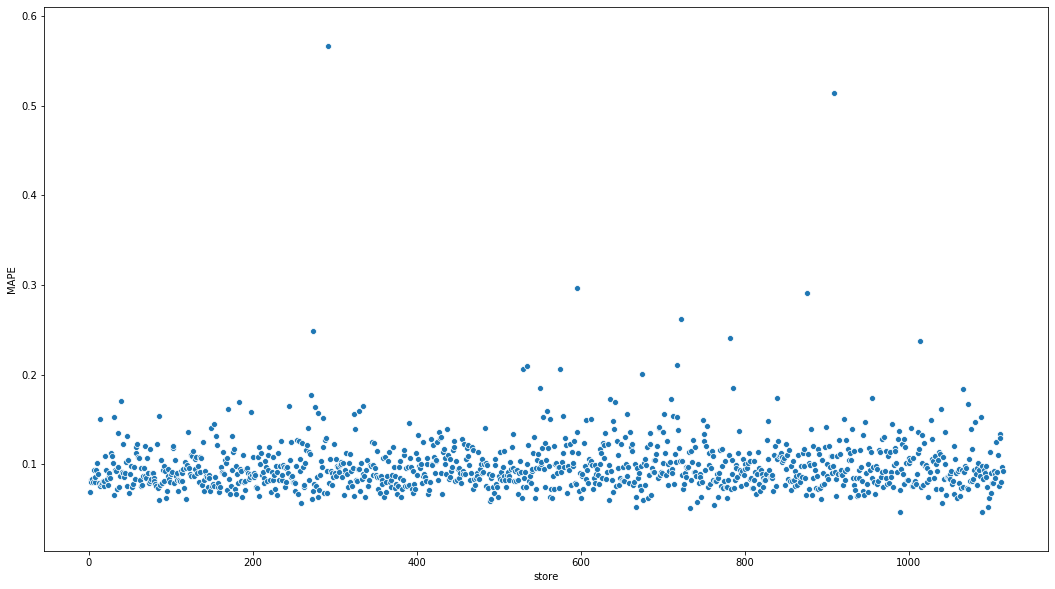

In [14]:
sns.scatterplot( x='store', y='MAPE', data = df92).figure.set_size_inches(18,10);

> Analisando o grafico de disperção do MAPE, podemos perceber que a grande maioria das predições possuem um erro na casa de 10 a 20%. Porém algumas lojas fogem disto, tendo erros entre 20 a 30% e duas acima de 50%.

## 9.2. Total Performance

In [18]:
df93 = df92[ [ 'predictions', 'worst_scenario', 'best_scenario' ] ].apply( lambda x: np.sum( x ), axis = 0 ).reset_index().rename( columns={'index' : 'scenario', 0: 'Values'} )
df93['Values'] = df93['Values'].map( 'R${:,.2f}'.format )
df93

,scenario,Values
0,predictions,"R$286,922,284.07"
1,worst_scenario,"R$286,176,353.50"
2,best_scenario,"R$286,176,353.50"


## 9.3. Machine Learning Performance

In [23]:
# Add colum error and error_rate:
df9_csv[ 'error' ] = df9_csv[ 'sales' ] - df9_csv[ 'predictions' ]
df9_csv[ 'error_rate' ] = df9_csv[ 'predictions' ]/ df9_csv[ 'sales' ]

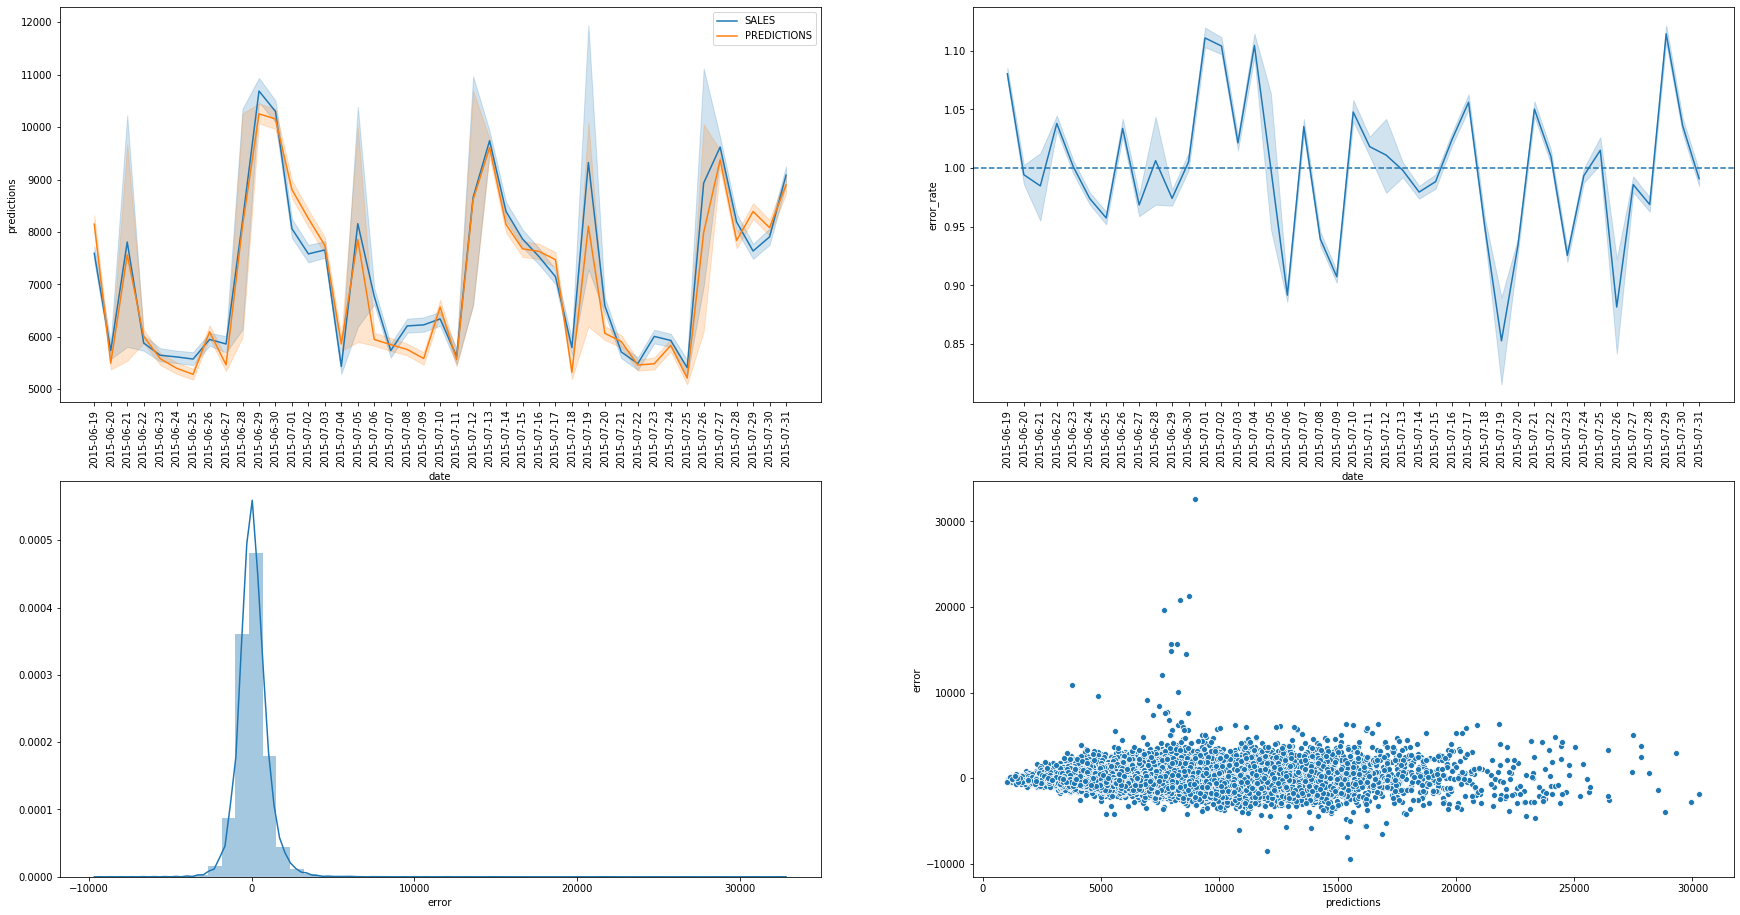

In [46]:
plt.subplot( 2,2,1).figure.set_size_inches(30, 16);
sns.lineplot( x='date', y='sales', data=df9_csv, label = 'SALES' );
sns.lineplot( x='date', y='predictions',  data = df9_csv, label = 'PREDICTIONS' );
plt.xticks( rotation = 90 );

plt.subplot( 2,2,2);
sns.lineplot( x='date', y='error_rate', data=df9_csv );
plt.axhline( 1, linestyle = '--');
plt.xticks( rotation = 90 );

plt.subplot( 2,2,3 );
sns.distplot( df9_csv['error'] );

plt.subplot( 2,2,4 );
sns.scatterplot( df9_csv['predictions'], df9_csv['error'] );